# INTERVIEW - BRUNO SERRA

## 1. Problem Definition

### 1.1 Objective

FabFitFun is a subscription box service that delivers a curated selection of beauty, wellness, and lifestyle products to its members. Each box typically includes a mix of full-sized items, ranging from skincare and makeup to home goods and fitness accessories. FabFitFun offers seasonal boxes four times a year and aims to provide high-quality products tailored to its subscribers' preferences. 

### 1.2 Key Questions and Insights

* Who are our most valuable members? How are they different from our less valuable members?
* Which channels are best at driving these members to sales?
* Where are purchase conversion rates strong?
* Based on your analysis, provide actionable recommendations to improve the conversion rate from visits to purchases. Explain the rationale behind each recommendation.

### 1.3 Dataset Attributes

Acquisitions
| Column                      | Definition                                                  |
|----------------------------|-------------------------------------------------------------|
| userID                     | Unique identifier for the user.                            |
| ACQUISITION_DATE           | Date the user made the acquisition.                        |
| ORDER_SEASON               | Season when the acquisition occurred.                      |
| PLAN_CODE                  | Code identifying the plan purchased by the user.           |
| SAME_DAY_REFUND            | Indicates if a same-day refund was issued.                 |
| CURRENT_SUBSCRIPTIONS_STATE | Current state of the user's subscription.                 |
| AGE                        | Age of the user at the time of acquisition.                |
| USER_REGION                | User's region of origin.                                   |
| LTV14 (in cents)           | User's 14-day Lifetime Value (LTV) in cents.               |


Visits
| Column                  | Definition                                                                 |
|------------------------|----------------------------------------------------------------------------|
| userID                 | Unique identifier for the user.                                            |
| SEASON                 | Season when the acquisition occurred.                                     |
| CAMPAIGN_ID            | Unique identifier for the marketing campaign.                             |
| WINDOW_NUMBER          | Campaign window within the season (Window 1 for Annual, 2 for Quarterly). |
| CAMPAIGN_TITLE         | Name of the campaign.                                                      |
| CAMPAIGN_TYPE          | Type of campaign.                                                          |
| WINDOW_START_TS_PST    | Start timestamp of the campaign window in PST.                            |
| WINDOW_END_TS_PST      | End timestamp of the campaign window in PST.                              |
| CHANNEL                | Channel through which the campaign was delivered.                         |
| NEW_OR_RETURNING_MEMBER | Indicates whether the user is a new or returning member.                 |
| VISIT_CNT              | Number of visits made by the user during the campaign window.             |


Purchases
| Column         | Definition                                            |
|----------------|-------------------------------------------------------|
| userID         | Unique identifier for the user.                       |
| CAMPAIGN_ID    | Unique identifier for the marketing campaign.         |
| CAMPAIGN_TITLE | Name of the campaign.                                 |
| SKU            | Unique identifier for the purchased product.          |
| CART_QUANTITY  | Quantity of the SKU added to the cart.                |
| MSRP           | Manufacturer's Suggested Retail Price of the product.|
| COGS           | Cost of Goods Sold for the product.                   |
| SALE_PRICE     | Actual price at which the product was sold.           |
| CATEGORY       | Product category or classification.                   |

Campaign (DIM)
| Column         | Definition                                          |
|----------------|-----------------------------------------------------|
| SEASON         | Season when the acquisition occurred.              |
| CAMPAIGN_ID    | Unique identifier for the marketing campaign.      |
| CAMPAIGN_TITLE | Name of the campaign.                              |
| CAMPAIGN_TYPE  | Type of campaign.                                  |


### 1.4 Imports

In [1]:
import pandas as pd
import numpy as np
import os
import requests
import chardet
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
from pandas import Timestamp
import warnings
warnings.filterwarnings("ignore")
from datetime import timedelta
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.decomposition import PCA

## 2 Data Collection

### 3.1 Import Files

In [2]:
# Importing xls file
home_exercise = r'D:\Bruno Serra PC\Documents\Bruno\GitHub\sales-membership-analysis\DA Take Home Exercise - Bruno.xlsx'

# Creating dataframes
fact_acquisitions_df = pd.read_excel(home_exercise, sheet_name='acquisitions')
fact_visits_df = pd.read_excel(home_exercise, sheet_name='visits')
fact_purchases_df = pd.read_excel(home_exercise, sheet_name='purchases')
dim_campaign_df = pd.read_excel(home_exercise, sheet_name='dim_campaign')

# Dictionary with all datasets
dfs = {
    "fact_acquisitions_df": fact_acquisitions_df,
    "fact_visits_df": fact_visits_df,
    "fact_purchases_df": fact_purchases_df,
    "dim_campaign_df": dim_campaign_df
}

### 3.2 Data Structure Analysis

#### 3.2.1 Overview

In [3]:
# Creating function to check the overview of df
def df_overview(df):
    print("Columns:", df.columns.tolist())
    print("Shape:", df.shape)
    print("-" * 20)

In [4]:
# Print overview
for name, df in dfs.items():
    print(f"Data set: {name}")
    df_overview(df)

Data set: fact_acquisitions_df
Columns: ['userID', 'ACQUISITION_DATE', 'ORDER_SEASON', 'PLAN_CODE', 'SAME_DAY_REFUND', 'CURRENT_SUBSCRIPTIONS_STATE', 'AGE', 'USER_REGION', 'LTV14 (in cents)']
Shape: (1800, 9)
--------------------
Data set: fact_visits_df
Columns: ['userID', 'SEASON', 'CAMPAIGN_ID', 'WINDOW_NUMBER', 'CAMPAIGN_TITLE', 'CAMPAIGN_TYPE', 'WINDOW_START_TS_PST', 'WINDOW_END_TS_PST', 'CHANNEL', 'NEW_OR_RETURNING_MEMBER', 'VISIT_CNT']
Shape: (17112, 11)
--------------------
Data set: fact_purchases_df
Columns: ['userID', 'CAMPAIGN_ID', 'CAMPAIGN_TITLE', 'SKU', 'CART_QUANTITY', 'MSRP', 'COGS', 'SALE_PRICE', 'CATEGORY']
Shape: (16064, 9)
--------------------
Data set: dim_campaign_df
Columns: ['SEASON', 'CAMPAIGN_ID', 'CAMPAIGN_TITLE', 'CAMPAIGN_TYPE']
Shape: (115, 4)
--------------------


In [5]:
# Data types
for name, df in dfs.items():
    print(f"===== {name} =====")
    print(df.dtypes)
    print("-" * 50 + "\n")

===== fact_acquisitions_df =====
userID                                 object
ACQUISITION_DATE               datetime64[ns]
ORDER_SEASON                            int64
PLAN_CODE                              object
SAME_DAY_REFUND                          bool
CURRENT_SUBSCRIPTIONS_STATE            object
AGE                                   float64
USER_REGION                            object
LTV14 (in cents)                      float64
dtype: object
--------------------------------------------------

===== fact_visits_df =====
userID                     object
SEASON                      int64
CAMPAIGN_ID                 int64
WINDOW_NUMBER               int64
CAMPAIGN_TITLE             object
CAMPAIGN_TYPE              object
WINDOW_START_TS_PST        object
WINDOW_END_TS_PST          object
CHANNEL                    object
NEW_OR_RETURNING_MEMBER    object
VISIT_CNT                   int64
dtype: object
--------------------------------------------------

===== fact_purchases

Let's transform some columns into the proper datatype.

In [6]:
# Age
fact_acquisitions_df['AGE'] = fact_acquisitions_df['AGE'].astype('Int64')

# Order season
fact_acquisitions_df['ORDER_SEASON'] = fact_acquisitions_df['ORDER_SEASON'].astype(str)

# Campaign Id
fact_visits_df['CAMPAIGN_ID'] = fact_visits_df['CAMPAIGN_ID'].astype(str)
fact_purchases_df['CAMPAIGN_ID'] = fact_purchases_df['CAMPAIGN_ID'].astype(str)
dim_campaign_df['CAMPAIGN_ID'] = dim_campaign_df['CAMPAIGN_ID'].astype(str)

# Window Start and End
fact_visits_df['WINDOW_START_TS_PST'] = pd.to_datetime(fact_visits_df['WINDOW_START_TS_PST'])
fact_visits_df['WINDOW_END_TS_PST'] = pd.to_datetime(fact_visits_df['WINDOW_END_TS_PST'])

# Season
fact_visits_df['SEASON'] = fact_visits_df['SEASON'].astype(str)
dim_campaign_df['SEASON'] = dim_campaign_df['SEASON'].astype(str)

# Window number
fact_visits_df['WINDOW_NUMBER'] = fact_visits_df['WINDOW_NUMBER'].astype(str)

In [7]:
# Data types
for name, df in dfs.items():
    print(f"===== {name} =====")
    print(df.dtypes)
    print("-" * 50 + "\n")

===== fact_acquisitions_df =====
userID                                 object
ACQUISITION_DATE               datetime64[ns]
ORDER_SEASON                           object
PLAN_CODE                              object
SAME_DAY_REFUND                          bool
CURRENT_SUBSCRIPTIONS_STATE            object
AGE                                     Int64
USER_REGION                            object
LTV14 (in cents)                      float64
dtype: object
--------------------------------------------------

===== fact_visits_df =====
userID                                  object
SEASON                                  object
CAMPAIGN_ID                             object
WINDOW_NUMBER                           object
CAMPAIGN_TITLE                          object
CAMPAIGN_TYPE                           object
WINDOW_START_TS_PST        datetime64[ns, UTC]
WINDOW_END_TS_PST          datetime64[ns, UTC]
CHANNEL                                 object
NEW_OR_RETURNING_MEMBER              

#### 3.2.2 Display

In [8]:
# CheDisplay fact_acquisitions_df
fact_acquisitions_df.head()

,userID,ACQUISITION_DATE,ORDER_SEASON,PLAN_CODE,SAME_DAY_REFUND,CURRENT_SUBSCRIPTIONS_STATE,AGE,USER_REGION,LTV14 (in cents)
0,f36f6ff6938872f4312d0039bc461c34,2020-12-29,2004,Quarterly,False,expired,33,US-Midwest,4999.0
1,c6070e19ec69cd31b8df15271b0beb6d,2020-11-20,2004,Quarterly,False,expired,<NA>,US-Midwest,4999.0
2,f034d172df46a1b8c487c0b60927921d,2020-03-31,2001,Quarterly,False,expired,52,US-West,4999.0
3,48bf3ec61e49906db974325c74b7c0e5,2020-08-13,2003,Quarterly,False,expired,<NA>,US-Midwest,4999.0
4,50fe89732a317efa52319ef94ee34bbe,2020-12-29,2004,Quarterly,False,expired,47,US-Midwest,4999.0


In [9]:
# CheDisplay fact_visits_df
fact_visits_df.head()

,userID,SEASON,CAMPAIGN_ID,WINDOW_NUMBER,CAMPAIGN_TITLE,CAMPAIGN_TYPE,WINDOW_START_TS_PST,WINDOW_END_TS_PST,CHANNEL,NEW_OR_RETURNING_MEMBER,VISIT_CNT
0,b59d5d8b8bfabdd47d9dec9f7affdee6,2204,145,1,Evergreen Shop 2021,Shop,2021-10-08 09:45:04+00:00,2023-02-09 12:59:50+00:00,Non-Attributed,returning,4
1,698c843aef4302d630f3934d5262d0b4,2302,209,1,Summer Add Ons 2023,Add-Ons,2023-04-27 09:00:00+00:00,2023-05-02 23:59:59+00:00,mobile_ios,returning,3
2,3a8aa9fd9257236586c89d8510389d79,2401,247,2,Spring 2024 Customize Boost,Boost,2024-02-09 09:00:00+00:00,2024-02-13 23:59:59+00:00,mobile_ios,returning,2
3,8291284d304a2379ea29c088fee5e8bf,2304,232,1,Winter Add Ons 2023,Add-Ons,2023-10-19 09:00:00+00:00,2023-10-24 23:59:59+00:00,mobile_ios,returning,3
4,fe98efcd31abfc86174966b48fbb1da6,2204,180,1,Black Friday 2022,Flash,2022-11-17 09:00:00+00:00,2022-11-20 23:59:59+00:00,Non-Attributed,returning,4


In [10]:
# CheDisplay fact_purchases_df
fact_purchases_df.head(10)

,userID,CAMPAIGN_ID,CAMPAIGN_TITLE,SKU,CART_QUANTITY,MSRP,COGS,SALE_PRICE,CATEGORY
0,c805311614ffdce7c072fe7f8fd2d819,161,Summer Add Ons 2022,IDI-HO-775-DS,1,24.99,9.00,19.00,Beauty
1,b457a1f041c3efd6f61407767c3610a8,119,Summer Add Ons 2021,2102-GWP-001,1,0.00,2.43,0.00,NaN
2,5062ab6c9283ae2d386fc112b62cabbe,97,Winter Add Ons 2020,ZOE-BE-026,1,29.99,3.30,9.00,Beauty
3,c89845baa12a0a8dc8068c37bf155fbe,76,Summer 2020 Add-Ons,THI-HO-001,1,34.00,1.70,9.00,Wellness
4,6c98a29e875bfb651918f2fd82956426,76,Summer 2020 Add-Ons,LAI-BE-007,1,46.00,6.00,17.00,Beauty
5,efc14d197c02b041a519d7463562fdbf,76,Summer 2020 Add-Ons,FUT-LI-001,1,29.95,3.30,9.00,Fashion
6,a9464b4965fba67e798f4738abca5735,164,Summer 2022 Incremental Sale,RKA-BE-001,1,56.00,5.80,5.99,Beauty
7,a9464b4965fba67e798f4738abca5735,164,Summer 2022 Incremental Sale,DUC-BE-002,3,15.00,2.30,2.99,Beauty
8,a9464b4965fba67e798f4738abca5735,164,Summer 2022 Incremental Sale,FRZ-BE-002,1,50.00,6.60,8.99,Beauty
9,a9464b4965fba67e798f4738abca5735,164,Summer 2022 Incremental Sale,RER-BE-001,2,23.00,2.70,4.99,Beauty


In [11]:
# Display dim_campaign_df
dim_campaign_df.head()

,SEASON,CAMPAIGN_ID,CAMPAIGN_TITLE,CAMPAIGN_TYPE
0,2104,107,New Member Add Ons (Post 2004),New Member
1,2104,144,Winter Add Ons 2021,Add-Ons
2,2104,145,Evergreen Shop 2021,Shop
3,2104,147,Winter 2021 Customize Boost,Boost
4,2104,148,Black Friday 2021,Flash


Insights:
* fact_visits_df HAS A PK OF userID + CAMPAIGN_ID + WINDOW_NUMBER

### 3.3 Descriptive Statistics

#### 3.3.1 Quantitative Variables

##### 3.3.1.1 Outliers

In [12]:
def numeric_boxplots(df, title=None, color="#FF5C5C"):
    all_numeric_data = []

    # Coleta colunas numéricas de cada tabela
    for name, df in dfs.items():
        if name == 'dim_campaign_df':
            continue  # Ignorar essa se não for relevante
        numeric_cols = df.select_dtypes(include=['number']).columns
        if len(numeric_cols) == 0:
            continue
        renamed = df[numeric_cols].add_prefix(f"{name} - ")
        all_numeric_data.append(renamed)

    if not all_numeric_data:
        print("No numeric data to plot.")
        return

    # Concatena tudo horizontalmente
    combined_df = pd.concat(all_numeric_data, axis=1)

    # Plot boxplot
    plt.figure(figsize=(max(12, 0.5 * combined_df.shape[1]), 8))

    plt.boxplot(
        combined_df.dropna().values,
        patch_artist=True,
        boxprops=dict(facecolor=color, color='black'),
        medianprops=dict(color='black'),
        whiskerprops=dict(color='black'),
        capprops=dict(color='black'),
        flierprops=dict(markerfacecolor='black', marker='o', markersize=5)
    )

    plt.xticks(range(1, len(combined_df.columns) + 1), combined_df.columns, rotation=90)
    plt.title("Boxplots de todas as colunas numéricas (todas as tabelas)")
    plt.grid(True, linestyle='--', alpha=0.5, axis='y')
    plt.tight_layout()
    plt.show()

Boxplot for: fact_acquisitions_df


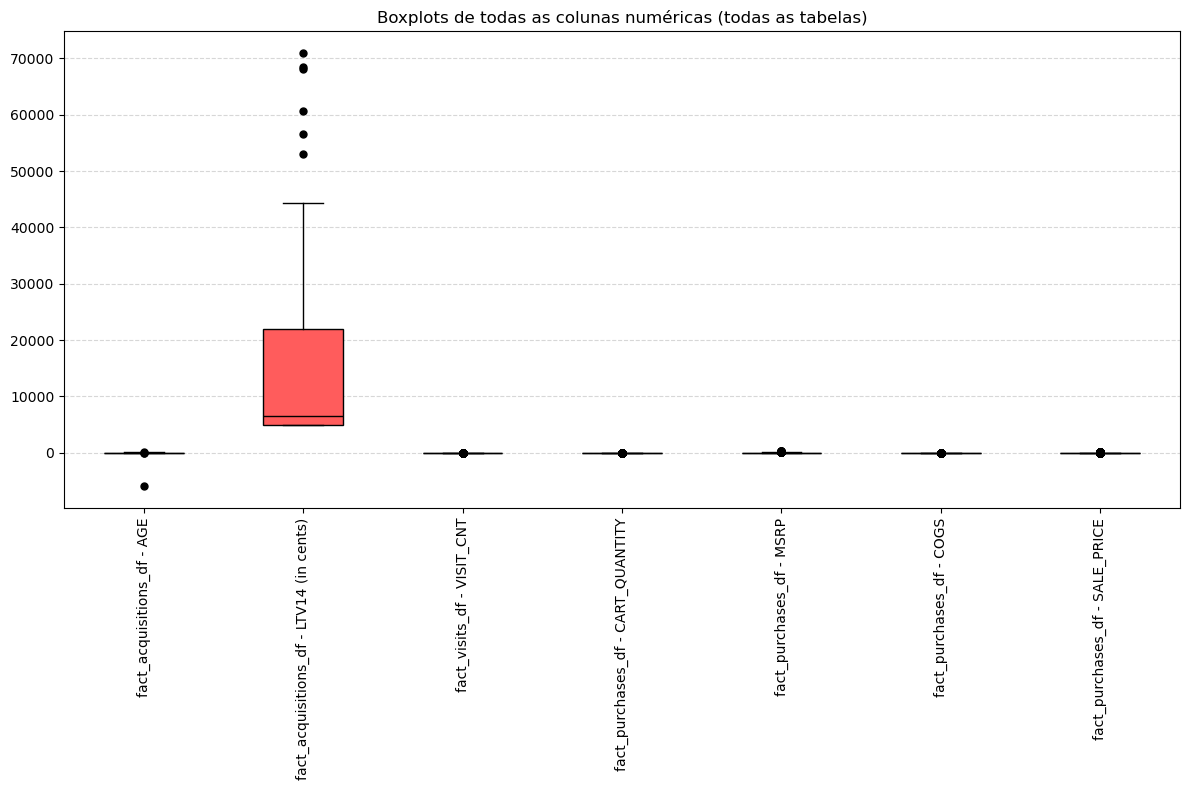

Boxplot for: fact_visits_df


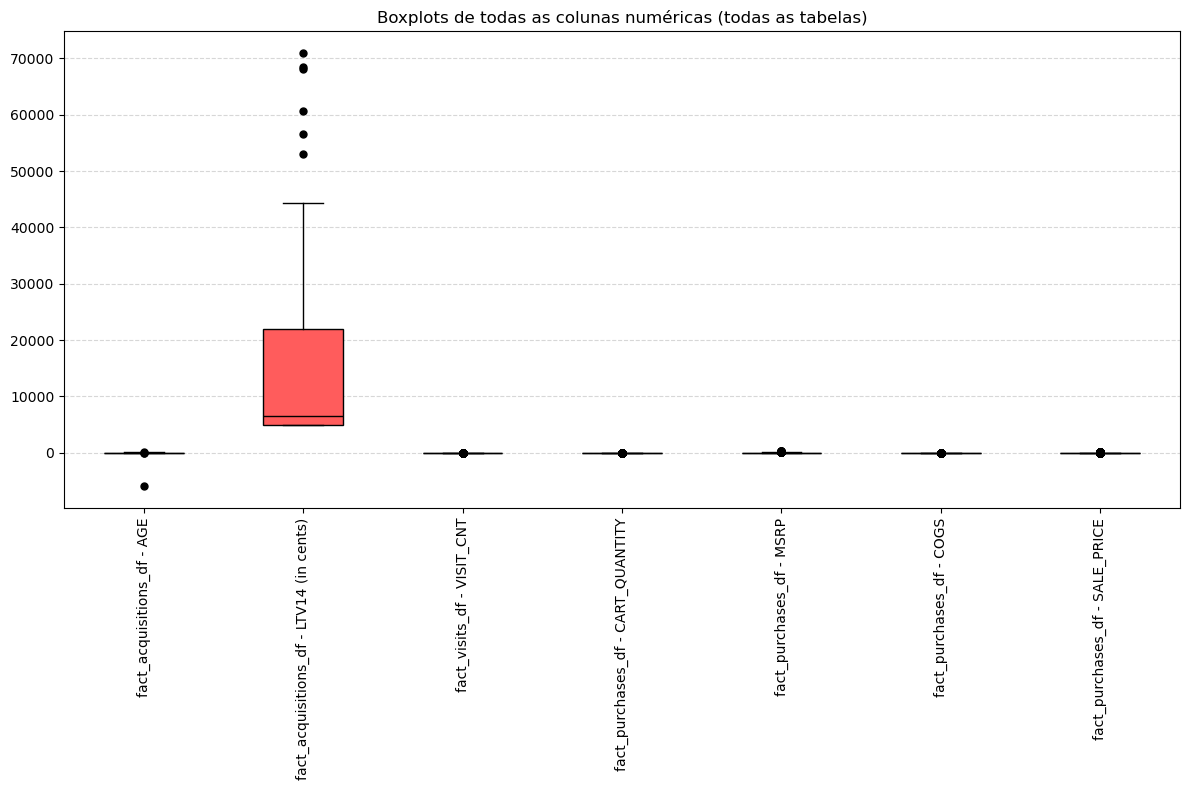

Boxplot for: fact_purchases_df


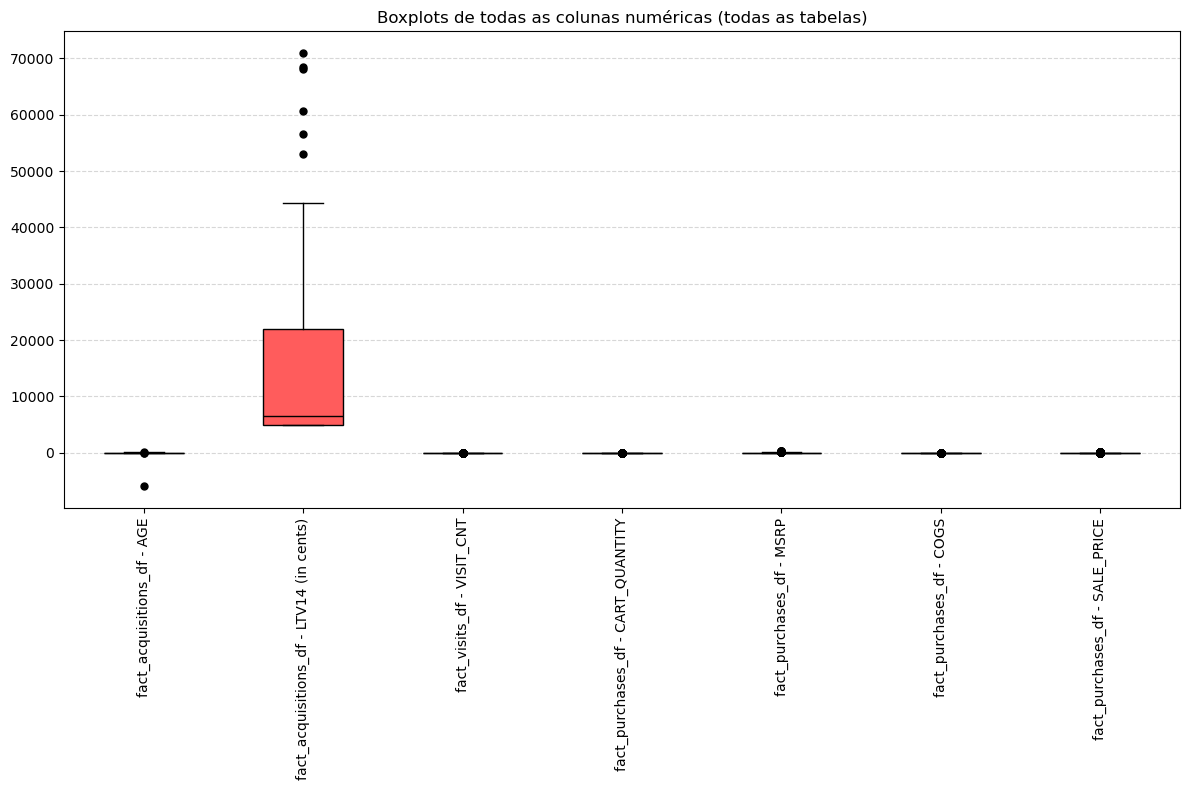

In [13]:
# Boxplots em uma imagem só por DataFrame
for name, df in dfs.items():
    if name != 'dim_campaign_df':
        print(f"Boxplot for: {name}")
        numeric_boxplots(df, title=name)

For the analysis above, we can see that:
* `fact_acquisitions_df (AGE)` - several outliers that are WRONG, so they should be dropped
* `fact_acquisitions_df (LTV14)` - several outliers but we can't assume it's wrong or not, but since they are not much, we'll keep them
* `fact_visits_df (VISIT_CNT)` - We can't assume it's wrong, we'll keep it
* `fact_purchases_df (CART_QUANTITY)` - A few outliers but we can't assume it's wrong or not, but since they are not much, we'll keep them
* `fact_purchases_df (MSRP)` - A few outliers but we can't assume it's wrong or not, but since they are not much, we'll keep them
* `fact_purchases_df (COGS)` - A few outliers but we can't assume it's wrong or not, but since they are not much, we'll keep them
* `fact_purchases_df (SALE_PRICE)` - A few outliers but we can't assume it's wrong or not


##### 3.3.1.2 Distributions

In [14]:
def numeric_histograms(df, color="#FF5C5C", bins=30):
    numeric_cols = df.select_dtypes(include=['number']).columns

    for col in numeric_cols:
        plt.figure(figsize=(6, 4))
        plt.hist(df[col].dropna(), bins=bins, color=color, edgecolor='black')
        plt.title(f'Histogram of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

Boxlot for: fact_acquisitions_df:


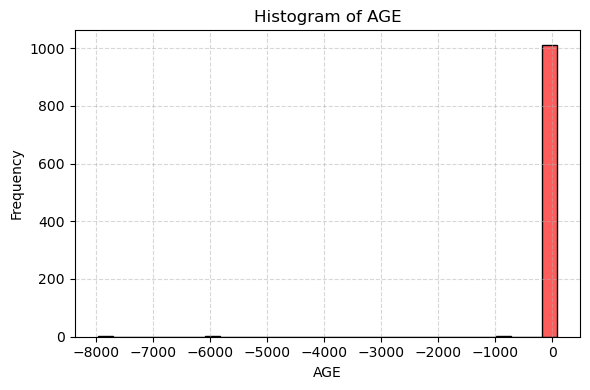

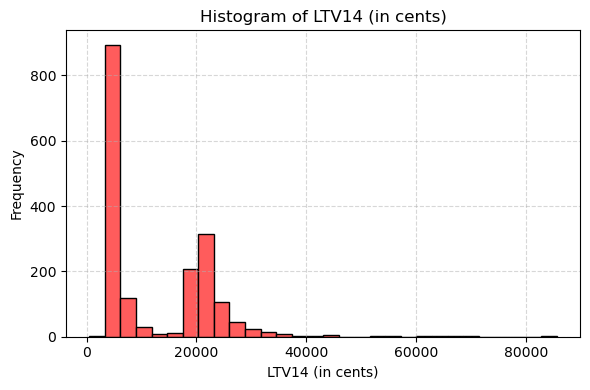

Boxlot for: fact_visits_df:


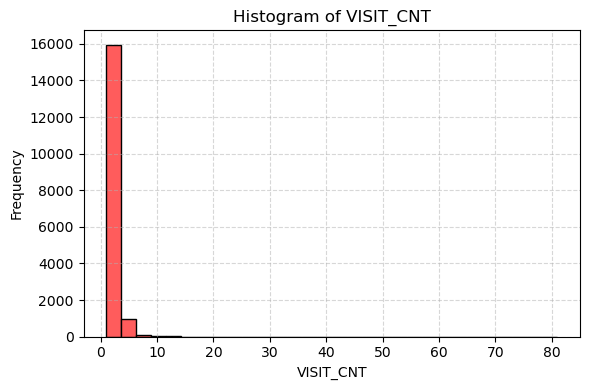

Boxlot for: fact_purchases_df:


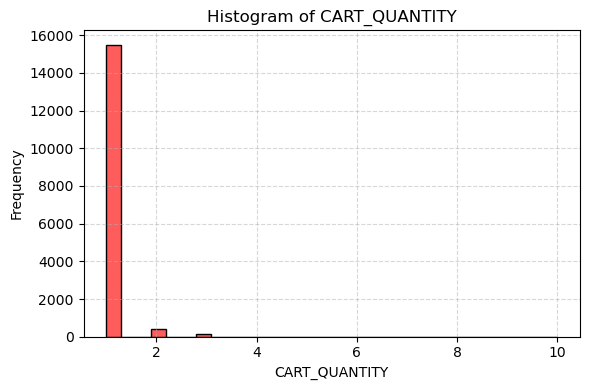

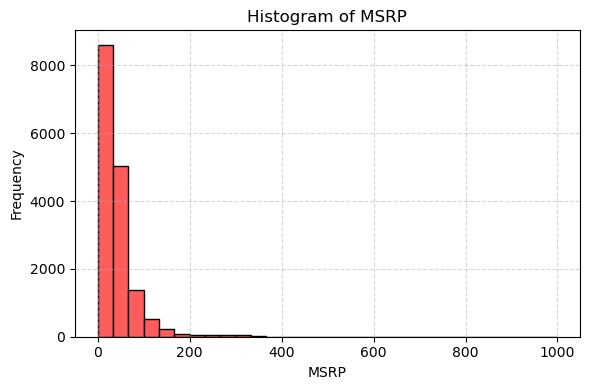

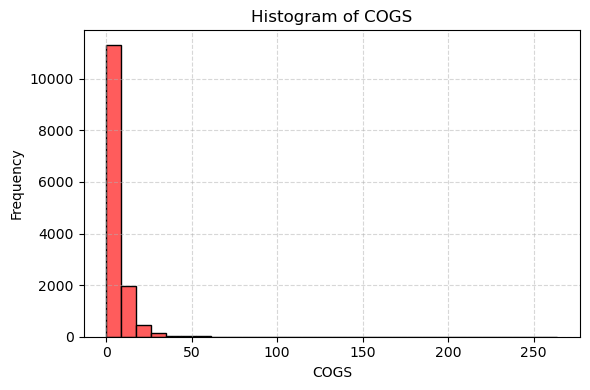

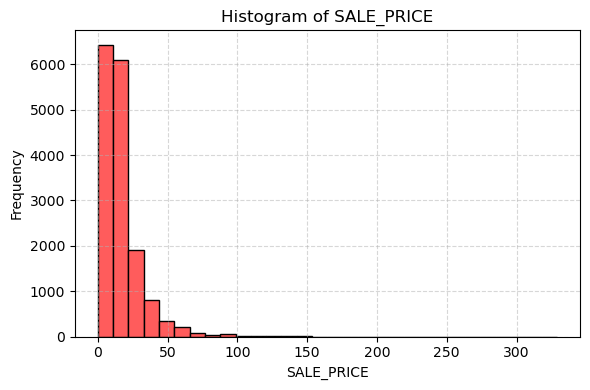

In [15]:
# 
for name, df in dfs.items():
    if name != 'dim_campaign_df':
        print(f"Boxlot for: {name}:")
        numeric_histograms(df)

#### 3.3.2 Qualitative Variables

Check if the users from the tables are unique (PK) or not.

In [16]:
# Function for uniqueness
def check_unique(df, name):
    if df['userID'].is_unique:
        print(f"{name}: The userID IS unique in this table.")
    else:
        print(f"{name}: The userID IS NOT unique in this table.")

In [17]:
# Check uniqueness
check_unique(fact_purchases_df, "fact_purchases_df")
check_unique(fact_visits_df, "fact_visits_df")
check_unique(fact_acquisitions_df, "fact_acquisitions_df")

fact_purchases_df: The userID IS NOT unique in this table.
fact_visits_df: The userID IS NOT unique in this table.
fact_acquisitions_df: The userID IS unique in this table.


Check the unique values for each categorical column.

In [18]:
# Unique values for qualitative variables
def unique_values(df):
    obj_cols = df.select_dtypes(include=['object', 'string']).columns
    for col in obj_cols:
        n_unique = df[col].nunique(dropna=False)
        print(f"{col}: {n_unique}")

In [19]:
# Display 
for name, df in dfs.items():
    print(f'Unique values in {name}: ')
    unique_values(df)
    print(f'\n')

Unique values in fact_acquisitions_df: 
userID: 1800
ORDER_SEASON: 18
PLAN_CODE: 2
CURRENT_SUBSCRIPTIONS_STATE: 3
USER_REGION: 8


Unique values in fact_visits_df: 
userID: 1327
SEASON: 12
CAMPAIGN_ID: 98
WINDOW_NUMBER: 2
CAMPAIGN_TITLE: 96
CAMPAIGN_TYPE: 6
CHANNEL: 8
NEW_OR_RETURNING_MEMBER: 3


Unique values in fact_purchases_df: 
userID: 985
CAMPAIGN_ID: 180
CAMPAIGN_TITLE: 176
SKU: 8093
CATEGORY: 17


Unique values in dim_campaign_df: 
SEASON: 13
CAMPAIGN_ID: 110
CAMPAIGN_TITLE: 108
CAMPAIGN_TYPE: 6




Now, check the quantity of values per attribute.

In [20]:
# Function to check categorical distributions
def categorical_distributions(df, categorical_columns, color="#FF5C5C"):
    for col in categorical_columns:
        counts = df[col].value_counts(dropna=False)  # inclui NaNs
        plt.figure(figsize=(8, 4))
        counts.plot(kind='bar', color=color, edgecolor='black')
        plt.title(f"Value Counts of '{col}'")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

Dim Campaing:

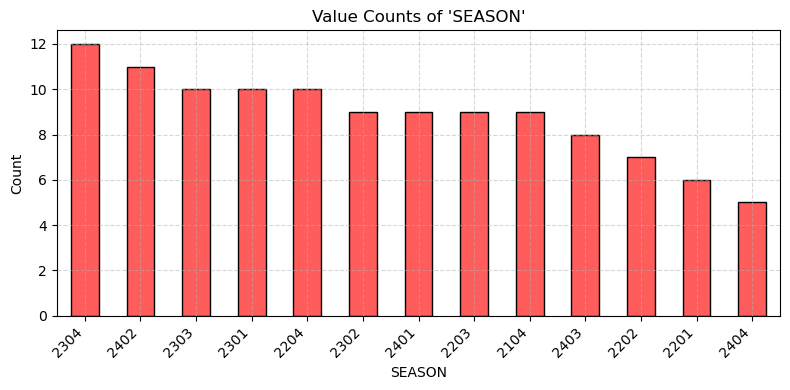

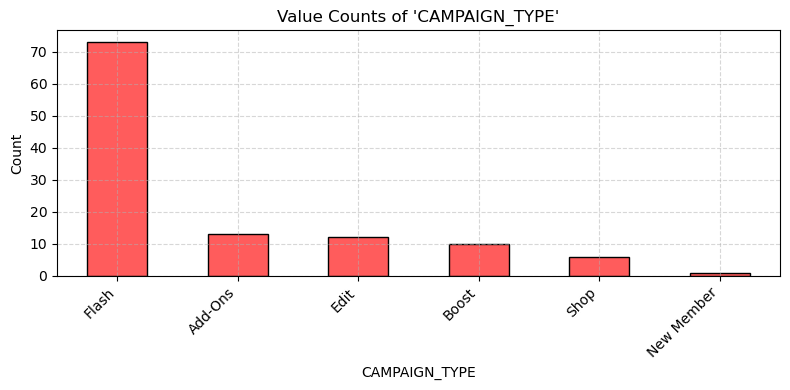

In [21]:
dim_campaign_cat_columns = ['SEASON', 'CAMPAIGN_TYPE']
categorical_distributions(dim_campaign_df, dim_campaign_cat_columns)

Purchases:

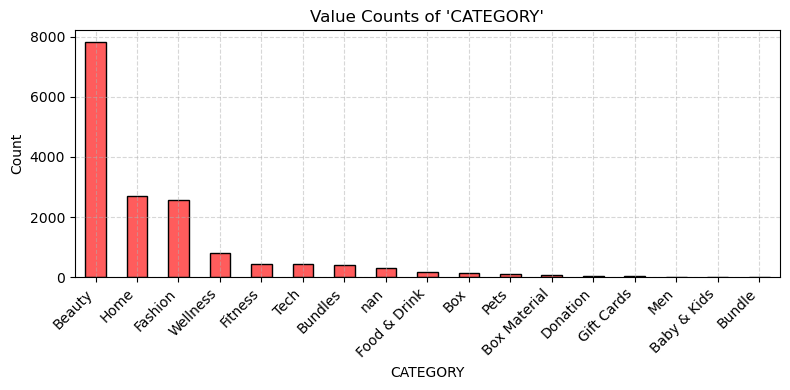

In [22]:
fact_purchases_cat_columns = ['CATEGORY']
categorical_distributions(fact_purchases_df, fact_purchases_cat_columns)

Visits:

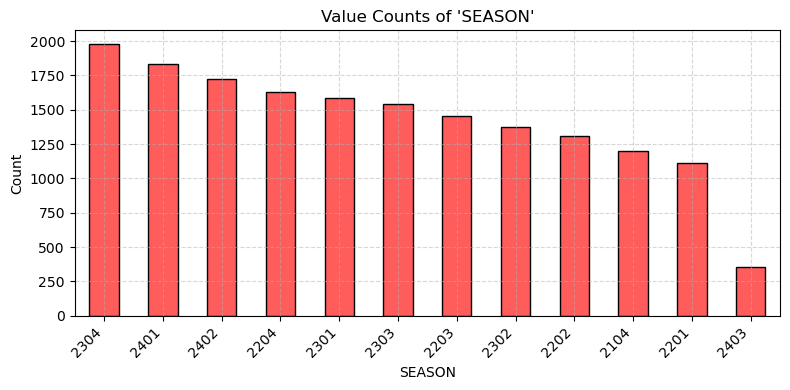

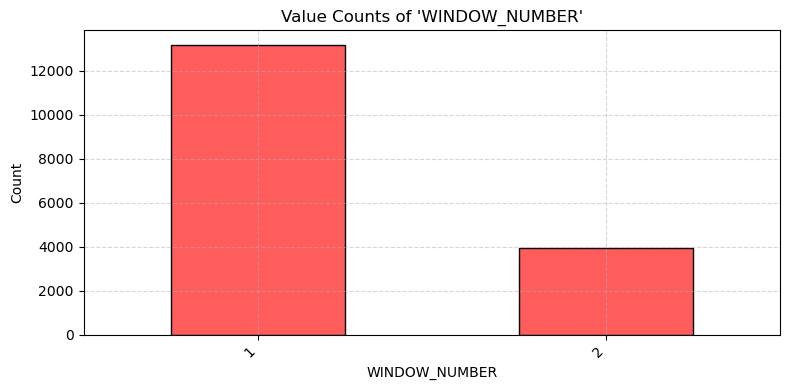

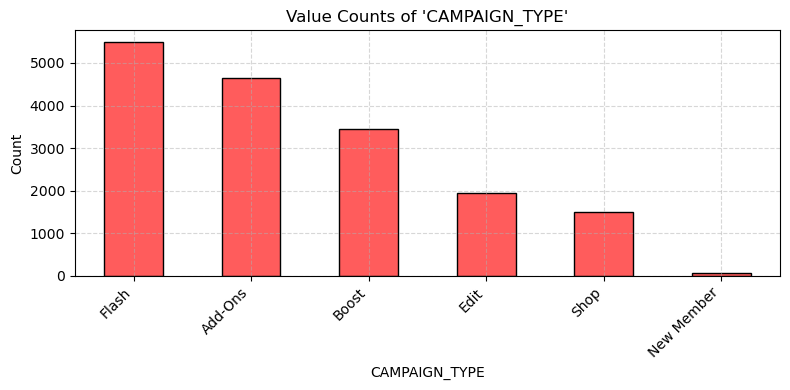

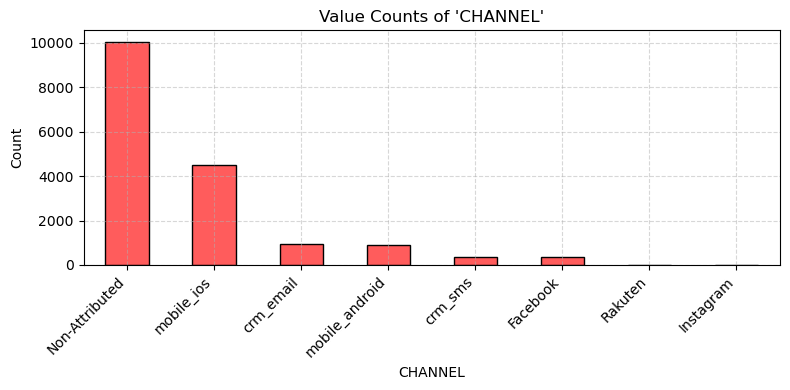

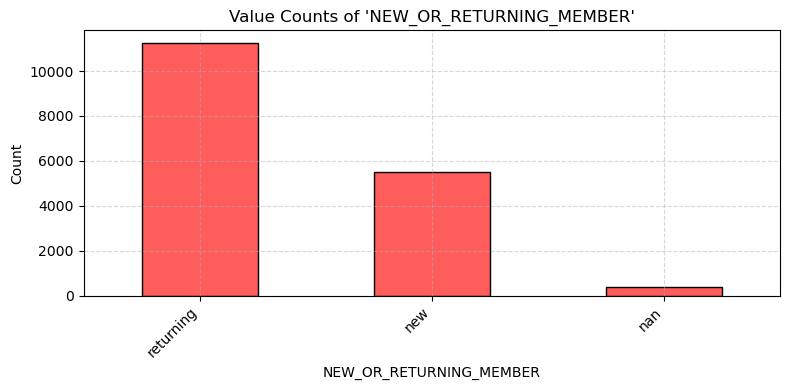

In [23]:
fact_visits_cat_columns = ['SEASON', 'WINDOW_NUMBER', 'CAMPAIGN_TYPE', 'CHANNEL', 'NEW_OR_RETURNING_MEMBER']
categorical_distributions(fact_visits_df, fact_visits_cat_columns)

Acquisition:

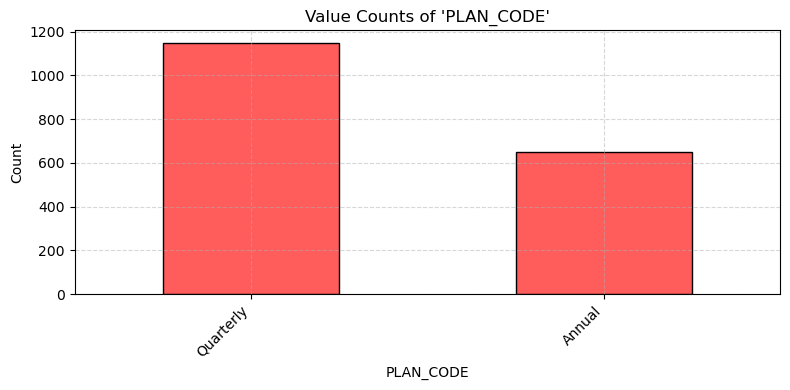

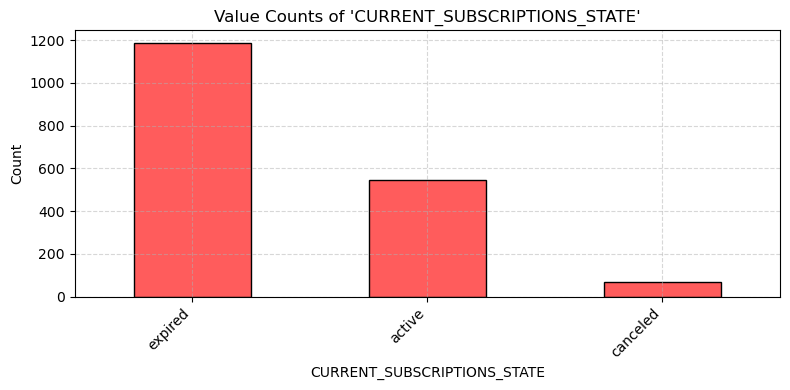

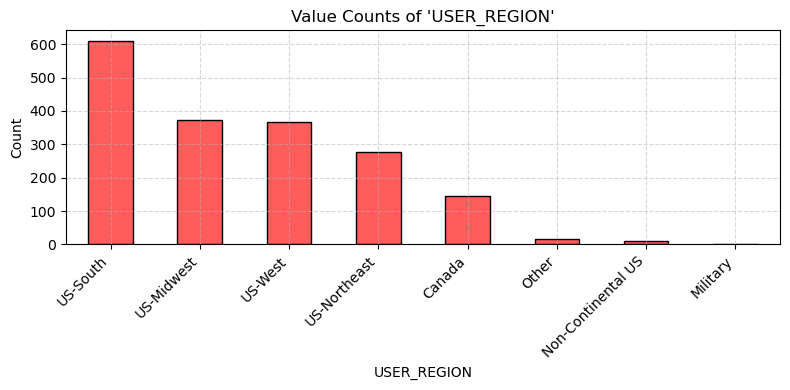

In [24]:
fact_acquisitions_cat_columns = ['PLAN_CODE', 'CURRENT_SUBSCRIPTIONS_STATE', 'USER_REGION']
categorical_distributions(fact_acquisitions_df, fact_acquisitions_cat_columns)

#### 3.3.1 Data GAP (INCONSISTANCES)

##### 3.3.1.1 Unique Campaigns in Purchases, Visits and Dim

In [25]:
# Unique campaign IDs from each table
purchases_campaigns = set(fact_purchases_df['CAMPAIGN_ID'].dropna().unique())
visits_campaigns = set(fact_visits_df['CAMPAIGN_ID'].dropna().unique())
dim_campaigns = set(dim_campaign_df['CAMPAIGN_ID'].dropna().unique())

# Print counts of unique campaign IDs per table
print(f"Unique CAMPAIGN_IDs in fact_purchases_df: {len(purchases_campaigns)}")
print(f"Unique CAMPAIGN_IDs in fact_visits_df: {len(visits_campaigns)}")
print(f"Unique CAMPAIGN_IDs in dim_campaign_df: {len(dim_campaigns)}")

# Compute intersection across all three tables
campaigns_in_all_three = purchases_campaigns & visits_campaigns & dim_campaigns
print(f"CAMPAIGN_IDs present in all three tables: {len(campaigns_in_all_three)}")

Unique CAMPAIGN_IDs in fact_purchases_df: 180
Unique CAMPAIGN_IDs in fact_visits_df: 98
Unique CAMPAIGN_IDs in dim_campaign_df: 110
CAMPAIGN_IDs present in all three tables: 96


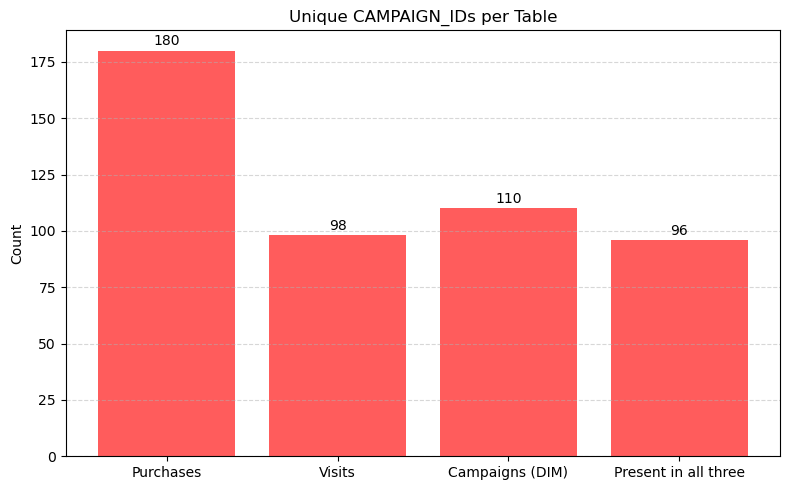

In [26]:
# Contagens
counts = {
    'Purchases': len(purchases_campaigns),
    'Visits': len(visits_campaigns),
    'Campaigns (DIM)': len(dim_campaigns),
    'Present in all three': len(campaigns_in_all_three)
}

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(counts.keys(), counts.values(), color='#FF5C5C')

# Adiciona rótulos nas barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, str(height), ha='center', va='bottom')

plt.title('Unique CAMPAIGN_IDs per Table')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

##### 3.3.1.2 Unique Users in Purchases and Visits

In [27]:
# Unique userIDs from each table
purchases_users = set(fact_purchases_df['userID'].dropna().unique())
visits_users = set(fact_visits_df['userID'].dropna().unique())

# Print counts of unique userIDs per table
print(f"Unique userIDs in fact_purchases_df: {len(purchases_users)}")
print(f"Unique userIDs in fact_visits_df: {len(visits_users)}")

# Compute intersection across both tables
users_in_both = purchases_users & visits_users
print(f"userIDs present in both tables: {len(users_in_both)}")


Unique userIDs in fact_purchases_df: 985
Unique userIDs in fact_visits_df: 1327
userIDs present in both tables: 873


Purchases: 985
Visits: 1327
Acquisitions: 1800
Present in all three: 873


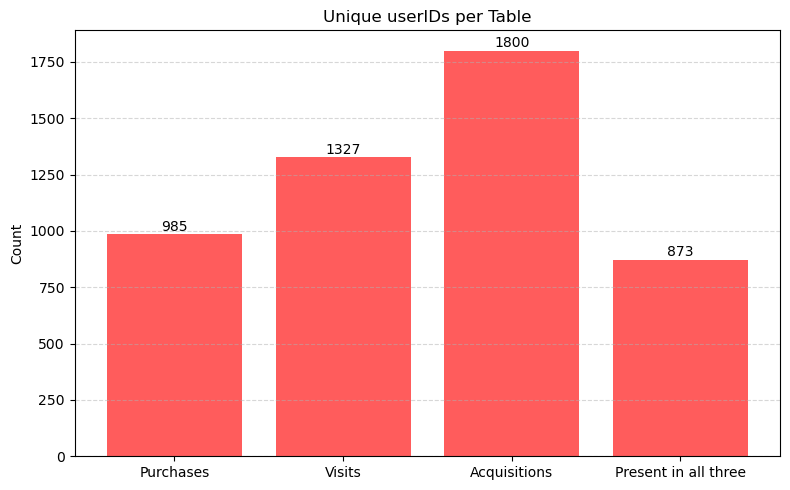

In [28]:
# Unique userIDs from each table
purchases_users = set(fact_purchases_df['userID'].dropna().unique())
visits_users = set(fact_visits_df['userID'].dropna().unique())
acquisitions_users = set(fact_acquisitions_df['userID'].dropna().unique())

# Interseção entre os três
users_in_all_three = purchases_users & visits_users & acquisitions_users

# Contagens
user_counts = {
    'Purchases': len(purchases_users),
    'Visits': len(visits_users),
    'Acquisitions': len(acquisitions_users),
    'Present in all three': len(users_in_all_three)
}

# Print resumo textual
for label, count in user_counts.items():
    print(f"{label}: {count}")

# Gráfico
plt.figure(figsize=(8, 5))
bars = plt.bar(user_counts.keys(), user_counts.values(), color='#FF5C5C')

# Rótulos nas barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, str(height), ha='center', va='bottom')

plt.title('Unique userIDs per Table')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#### 3.3.1.4 - Nulls, NaNs and Missings

In [29]:
# Function to check nulls
def nulls_evaluation(df, name):
    print(f"Dataframe: {name}")
    total_rows = len(df)
    pct_missing = (df.isnull().sum() / total_rows * 100).round(1)

    has_missing = False
    for col, pct in pct_missing.items():
        if pct > 0:
            print(f"{col}: {pct}%")
            has_missing = True

    if not has_missing:
        print("No missing values.")
    print("-" * 30)

In [30]:
# Check nulls for all dataframes
for name, df in dfs.items():
    nulls_evaluation(df, name)

Dataframe: fact_acquisitions_df
AGE: 43.7%
------------------------------
Dataframe: fact_visits_df
NEW_OR_RETURNING_MEMBER: 2.1%
------------------------------
Dataframe: fact_purchases_df
COGS: 12.7%
CATEGORY: 1.8%
------------------------------
Dataframe: dim_campaign_df
No missing values.
------------------------------


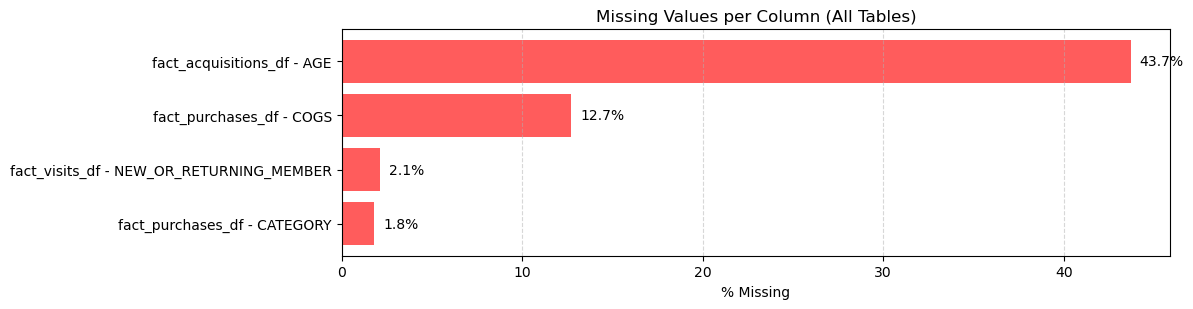

In [31]:
def plot_all_nulls_together(dfs, color="#FF5C5C"):
    nulls_summary = []

    for name, df in dfs.items():
        total_rows = len(df)
        pct_missing = (df.isnull().sum() / total_rows * 100).round(1)
        pct_missing = pct_missing[pct_missing > 0]

        for col, pct in pct_missing.items():
            nulls_summary.append((f"{name} - {col}", pct))

    if not nulls_summary:
        print("No missing values in any DataFrame.")
        return

    nulls_df = pd.DataFrame(nulls_summary, columns=["Column", "Percent"])
    nulls_df = nulls_df.sort_values(by="Percent", ascending=True)

    # Aumenta a altura vertical
    plt.figure(figsize=(12, 0.8 * len(nulls_df)))  # <-- aqui está o ajuste

    plt.barh(nulls_df["Column"], nulls_df["Percent"], color=color)

    for i, v in enumerate(nulls_df["Percent"]):
        plt.text(v + 0.5, i, f"{v}%", va='center')

    plt.title("Missing Values per Column (All Tables)")
    plt.xlabel("% Missing")
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

plot_all_nulls_together(dfs)


The dataset `fact_acquisitions_df` has a huge quantity of missing ages, meaning that we probably will not use this column.

#### 3.3.1.5 - Unique UserID, Unique Campaign, Unique UserID + Campaign ID (PK) in Both Tables

In [32]:
# Get only userID and CAMPAIGN_ID combinations from both tables
common_keys_drop = fact_purchases_df[['userID', 'CAMPAIGN_ID']].merge(
    fact_visits_df[['userID', 'CAMPAIGN_ID']],
    on=['userID', 'CAMPAIGN_ID'],
    how='inner'
).drop_duplicates()

common_keys = fact_purchases_df[['userID', 'CAMPAIGN_ID']].merge(
    fact_visits_df[['userID', 'CAMPAIGN_ID']],
    on=['userID', 'CAMPAIGN_ID'],
    how='inner'
)

# Check the number of common combinations
print(f"Number of common (userID, CAMPAIGN_ID) pairs: {len(common_keys_drop)}")
print(f"Number of common (userID, CAMPAIGN_ID) pairs without drop: {len(common_keys)}")

Number of common (userID, CAMPAIGN_ID) pairs: 3093
Number of common (userID, CAMPAIGN_ID) pairs without drop: 20949


#### 3.3.1.5 - Join Visits and Purchases

Let's join both tables to understand the situation due to lack of users and campaigns present in both tables. We'll perform a left join from purchaes to visits since purchases is the most important.

In [33]:
# Selecting columns
fact_visits_filtered = (
    fact_visits_df
    .sort_values('WINDOW_END_TS_PST')
    .drop_duplicates(subset=['userID', 'CAMPAIGN_ID'], keep='last')
    [['userID', 'CAMPAIGN_ID', 'WINDOW_START_TS_PST', 'WINDOW_END_TS_PST']]
)

# Left Join
result_df = fact_purchases_df.merge(
    fact_visits_filtered,
    on=['userID', 'CAMPAIGN_ID'],
    how='left'
)

# Null percentage for each column
null_percentages = result_df.isna().mean() * 100

# Display formatted result
print(null_percentages.round(2))

userID                  0.00
CAMPAIGN_ID             0.00
CAMPAIGN_TITLE          0.00
SKU                     0.00
CART_QUANTITY           0.00
MSRP                    0.00
COGS                   12.71
SALE_PRICE              0.00
CATEGORY                1.81
WINDOW_START_TS_PST    29.29
WINDOW_END_TS_PST      29.29
dtype: float64


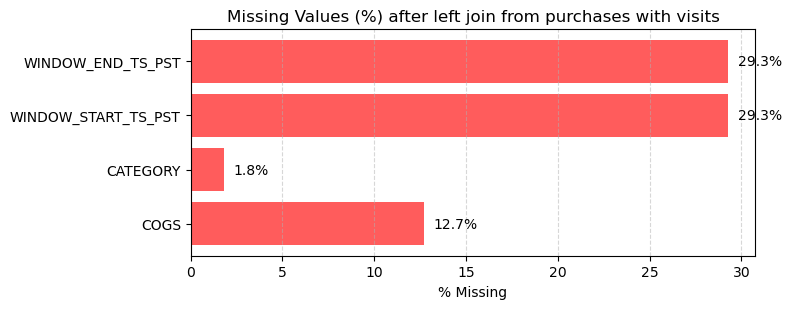

In [34]:
# Calcula % de valores nulos
null_percentages = (result_df.isna().mean() * 100).round(2)
null_percentages = null_percentages[null_percentages > 0]  # mostra só colunas com null

# Se tiver algo pra mostrar
if not null_percentages.empty:
    plt.figure(figsize=(8, 0.8 * len(null_percentages)))
    plt.barh(null_percentages.index, null_percentages.values, color="#FF5C5C")

    for i, v in enumerate(null_percentages.values):
        plt.text(v + 0.5, i, f"{v:.1f}%", va='center')

    plt.title("Missing Values (%) after left join from purchases with visits")
    plt.xlabel("% Missing")
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
else:
    print("No missing values in result_df.")

##### 3.3.1.6 Window Number

In [35]:
# Passo 1: Conta WINDOW_NUMBERs únicos por user + campaign
user_campaign_window_counts = (
    fact_visits_df[['userID', 'CAMPAIGN_ID', 'WINDOW_NUMBER']]
    .drop_duplicates()
    .groupby(['userID', 'CAMPAIGN_ID'])['WINDOW_NUMBER']
    .nunique()
    .reset_index(name='num_window_numbers')
)

# Passo 2: Filtra quem tem mais de 1 window number na mesma campanha
users_with_multiple_windows_same_campaign = user_campaign_window_counts[
    user_campaign_window_counts['num_window_numbers'] > 1
]

# Passo 3: Conta os usuários únicos que têm isso
num_users_multiple_windows_same_campaign = users_with_multiple_windows_same_campaign['userID'].nunique()

print(f"Usuários únicos que participaram de mais de uma janela na mesma campanha: {num_users_multiple_windows_same_campaign}")


Usuários únicos que participaram de mais de uma janela na mesma campanha: 421


In [36]:
# Passo 1: Conta quantos WINDOW_NUMBERs únicos o usuário teve por campanha
user_campaign_window_counts = (
    fact_visits_df[['userID', 'CAMPAIGN_ID', 'WINDOW_NUMBER']]
    .drop_duplicates()
    .groupby(['userID', 'CAMPAIGN_ID'])['WINDOW_NUMBER']
    .nunique()
    .reset_index(name='num_window_numbers')
)

# Passo 2: Agrupa por userID para verificar se ele teve sempre só 1 janela por campanha
users_summary = (
    user_campaign_window_counts
    .groupby('userID')['num_window_numbers']
    .max()
    .reset_index(name='max_window_count')
)

# Passo 3: Filtra os que **nunca** tiveram mais de uma janela por campanha
users_with_only_one_window_per_campaign = users_summary[users_summary['max_window_count'] == 1]

# Resultado final
print(f"Usuários únicos que participaram de apenas uma janela por campanha (sempre): {users_with_only_one_window_per_campaign.shape[0]}")


Usuários únicos que participaram de apenas uma janela por campanha (sempre): 906


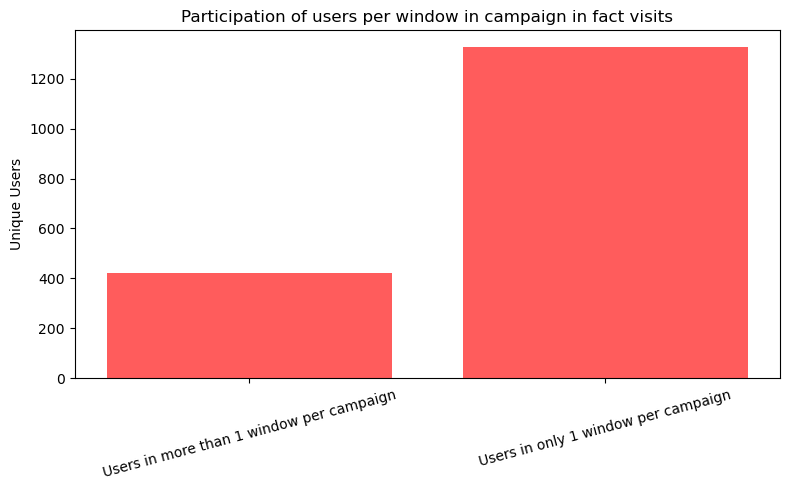

In [37]:
# Valores que você já calculou
num_users_multiple_windows_same_campaign = 421
num_users_only_one_window_per_campaign = 1327

# Rótulos e valores
labels = [
    'Users in more than 1 window per campaign',
    'Users in only 1 window per campaign'
]
values = [
    num_users_multiple_windows_same_campaign,
    num_users_only_one_window_per_campaign
]

# Criar o gráfico
plt.figure(figsize=(8, 5))
plt.bar(labels, values, color='#FF5C5C')
plt.ylabel('Unique Users')
plt.title('Participation of users per window in campaign in fact visits')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

## 3 Data Preprocessing

### 3.1 Null Treatment

For this perspective, we'll only consider userID + campaign_id available in both tables (visits and purchases), considering that for e-commerce applications, it's mostly not possible to purchase something without visiting the product.

To perform the join, we can't know exactly the channel the the person bought. So, we'll:
* Inner join the `fact_purchases_df` with `fact_visits_df` using `userID` and `CAMPAIGN_ID` AS KEYS 
* **ASSUMPTION:** Drop duplicates of `userID` and `CAMPAIGN_ID`, keeping the last one (because **we'll consider that the last visit is when the person bought the item**)

In [38]:
# Select only last visits
latest_visits_df = (
    fact_visits_df
    .sort_values('WINDOW_END_TS_PST')
    .drop_duplicates(subset=['userID', 'CAMPAIGN_ID'], keep='last')
)

# Joinning fact_purchases_df with fact_visits_df
purchases_dates_df = fact_purchases_df.merge(latest_visits_df[['WINDOW_END_TS_PST', 'userID', 'CAMPAIGN_ID', 'CHANNEL', 'WINDOW_NUMBER']], on=['userID', 'CAMPAIGN_ID'], how='inner')

# TOTAL_REVENUE
purchases_dates_df['TOTAL_REVENUE'] = (
    purchases_dates_df['CART_QUANTITY'] * purchases_dates_df['SALE_PRICE']
)

# Display
purchases_dates_df.head()

,userID,CAMPAIGN_ID,CAMPAIGN_TITLE,SKU,CART_QUANTITY,MSRP,COGS,SALE_PRICE,CATEGORY,WINDOW_END_TS_PST,CHANNEL,WINDOW_NUMBER,TOTAL_REVENUE
0,c805311614ffdce7c072fe7f8fd2d819,161,Summer Add Ons 2022,IDI-HO-775-DS,1,24.99,9.0,19.00,Beauty,2022-05-17 23:59:59+00:00,crm_email,2,19.00
1,a9464b4965fba67e798f4738abca5735,164,Summer 2022 Incremental Sale,RKA-BE-001,1,56.00,5.8,5.99,Beauty,2022-06-01 23:59:59+00:00,Non-Attributed,1,5.99
2,a9464b4965fba67e798f4738abca5735,164,Summer 2022 Incremental Sale,DUC-BE-002,3,15.00,2.3,2.99,Beauty,2022-06-01 23:59:59+00:00,Non-Attributed,1,8.97
3,a9464b4965fba67e798f4738abca5735,164,Summer 2022 Incremental Sale,FRZ-BE-002,1,50.00,6.6,8.99,Beauty,2022-06-01 23:59:59+00:00,Non-Attributed,1,8.99
4,a9464b4965fba67e798f4738abca5735,164,Summer 2022 Incremental Sale,RER-BE-001,2,23.00,2.7,4.99,Beauty,2022-06-01 23:59:59+00:00,Non-Attributed,1,9.98


In [39]:
# Calculating the new size of df
print(f"Old purchases has a length of {len(purchases_dates_df)}")
print(f"Old purchases has a length of {len(fact_purchases_df)}")
print(f"We kept round {round(len(purchases_dates_df) / len(fact_purchases_df) * 100, 2)}% of the rows")

Old purchases has a length of 11359
Old purchases has a length of 16064
We kept round 70.71% of the rows


In [40]:
# Calculating the new size of df
print(f"Number of users from initial table purchases {purchases_dates_df['userID'].nunique()}")
print(f"Number of users from new table purchases {fact_purchases_df['userID'].nunique()}")
print(f"We kept round {round(purchases_dates_df['userID'].nunique() / fact_purchases_df['userID'].nunique() * 100, 2)}% of the rows")

Number of users from initial table purchases 766
Number of users from new table purchases 985
We kept round 77.77% of the rows


In [41]:
# Calculating the new size of df
print(f"Number of campaigns from initial table purchases {purchases_dates_df['CAMPAIGN_ID'].nunique()}")
print(f"Number of campaigns from new table purchases {fact_purchases_df['CAMPAIGN_ID'].nunique()}")
print(f"We kept round {round(purchases_dates_df['CAMPAIGN_ID'].nunique() / fact_purchases_df['CAMPAIGN_ID'].nunique() * 100, 2)}% of the rows")

Number of campaigns from initial table purchases 96
Number of campaigns from new table purchases 180
We kept round 53.33% of the rows


Let's continue with the second option.

## 4 DATA ANALYSIS

### 4.1 Valuable Users - RFM



Calculate the R - RECENCY.

In [42]:
# Criar cópia
recency_df = purchases_dates_df.copy()

# Calcular reference_date e one_year_ago
reference_date = recency_df['WINDOW_END_TS_PST'].max()
one_year_ago = reference_date - timedelta(days=365)

# Filtrar para manter apenas registros do último ano
recency_df = recency_df[
    recency_df['WINDOW_END_TS_PST'].between(one_year_ago, reference_date)
].copy()

# Coletar a data mais recente de compra por userID
recency_df = (
    recency_df
    .groupby('userID')['WINDOW_END_TS_PST']
    .max()
    .reset_index()
)

# Calcular recency
recency_df['RECENCY'] = (reference_date - recency_df['WINDOW_END_TS_PST']).dt.days

# Manter apenas colunas finais
recency_df = recency_df[['userID', 'RECENCY']]

# Exibir resultado
recency_df.head()

,userID,RECENCY
0,00e1652e0a249f65810507ce2a6ded73,0
1,01186aab51de65876d40e758b398ac3a,273
2,011a108b9bbe8e6a494e23d2cf782f4a,20
3,015c290d8fc1087c0e835f513f1b924e,287
4,01653f6844293d8e9e6e6e736f78cdb3,105


Calculate the M - MONETARY.

In [43]:
# Filtering one year
one_year_ago = reference_date - timedelta(days=365)

# Filtering one year
recent_purchases = purchases_dates_df[
    purchases_dates_df['WINDOW_END_TS_PST'].between(one_year_ago, reference_date)
].copy()

# Monetary
monetary_df = (
    recent_purchases
    .groupby('userID')['TOTAL_REVENUE']
    .sum()
    .reset_index(name='MONETARY')
)

# Display
monetary_df.head()

,userID,MONETARY
0,00e1652e0a249f65810507ce2a6ded73,145.98
1,01186aab51de65876d40e758b398ac3a,35.00
2,011a108b9bbe8e6a494e23d2cf782f4a,11.00
3,015c290d8fc1087c0e835f513f1b924e,119.97
4,01653f6844293d8e9e6e6e736f78cdb3,157.98


Calculate the F - FREQUENCY.

In [44]:
# Frequency
frequency_df = (
    recent_purchases
    .groupby('userID')
    .size()
    .reset_index(name='FREQUENCY')
)

# Display
frequency_df.head()

,userID,FREQUENCY
0,00e1652e0a249f65810507ce2a6ded73,9
1,01186aab51de65876d40e758b398ac3a,2
2,011a108b9bbe8e6a494e23d2cf782f4a,1
3,015c290d8fc1087c0e835f513f1b924e,7
4,01653f6844293d8e9e6e6e736f78cdb3,10


Now, let's put it all together and create theis values.

In [45]:
# Merge all into one RFM DataFrame
rfm_df = (
    recency_df
    .merge(frequency_df, on='userID', how='left')
    .merge(monetary_df, on='userID', how='left')
)

# Display
rfm_df.head()

,userID,RECENCY,FREQUENCY,MONETARY
0,00e1652e0a249f65810507ce2a6ded73,0,9,145.98
1,01186aab51de65876d40e758b398ac3a,273,2,35.00
2,011a108b9bbe8e6a494e23d2cf782f4a,20,1,11.00
3,015c290d8fc1087c0e835f513f1b924e,287,7,119.97
4,01653f6844293d8e9e6e6e736f78cdb3,105,10,157.98


In [46]:
# Quantiles
quantiles = rfm_df[['RECENCY', 'FREQUENCY', 'MONETARY']].quantile(q=[0.25, 0.5, 0.75])

# Scoring function
def rfm_score(x, p, d):
    if p == 'RECENCY':
        if x <= d[p][0.25]:
            return 4
        elif x <= d[p][0.50]:
            return 3
        elif x <= d[p][0.75]:
            return 2
        else:
            return 1
    else:  # Frequency and Monetary
        if x <= d[p][0.25]:
            return 1
        elif x <= d[p][0.50]:
            return 2
        elif x <= d[p][0.75]:
            return 3
        else:
            return 4

# Apply scores
rfm_df['R'] = rfm_df['RECENCY'].apply(rfm_score, args=('RECENCY', quantiles))
rfm_df['F'] = rfm_df['FREQUENCY'].apply(rfm_score, args=('FREQUENCY', quantiles))
rfm_df['M'] = rfm_df['MONETARY'].apply(rfm_score, args=('MONETARY', quantiles))

# Combina os scores em uma string tipo "444"
rfm_df['RFM_Segment'] = (
    rfm_df['R'].astype(str) +
    rfm_df['F'].astype(str) +
    rfm_df['M'].astype(str)
)

# Soma os scores (ex: 4 + 4 + 4 = 12)
rfm_df['RFM_SCORE'] = (
    rfm_df['R'] +
    rfm_df['F'] +
    rfm_df['M']
)

# Definir a função de segmentação
def assign_segment(score):
    if score < 5:
        return 'Low-Value'
    elif score < 9:
        return 'Mid-Value'
    else:
        return 'High-Value'

# Aplicar a função ao DataFrame
rfm_df['RFM_SEGMENT_LABEL'] = rfm_df['RFM_SCORE'].apply(assign_segment)

# Exibir
rfm_df.head()

,userID,RECENCY,FREQUENCY,MONETARY,R,F,M,RFM_Segment,RFM_SCORE,RFM_SEGMENT_LABEL
0,00e1652e0a249f65810507ce2a6ded73,0,9,145.98,4,3,3,433,10,High-Value
1,01186aab51de65876d40e758b398ac3a,273,2,35.00,1,1,2,112,4,Low-Value
2,011a108b9bbe8e6a494e23d2cf782f4a,20,1,11.00,3,1,1,311,5,Mid-Value
3,015c290d8fc1087c0e835f513f1b924e,287,7,119.97,1,3,3,133,7,Mid-Value
4,01653f6844293d8e9e6e6e736f78cdb3,105,10,157.98,3,3,3,333,9,High-Value


In [47]:
# Count segments
segment_counts = rfm_df['RFM_SEGMENT_LABEL'].value_counts().sort_index()

segment_counts

RFM_SEGMENT_LABEL
High-Value    179
Low-Value      73
Mid-Value     199
Name: count, dtype: int64

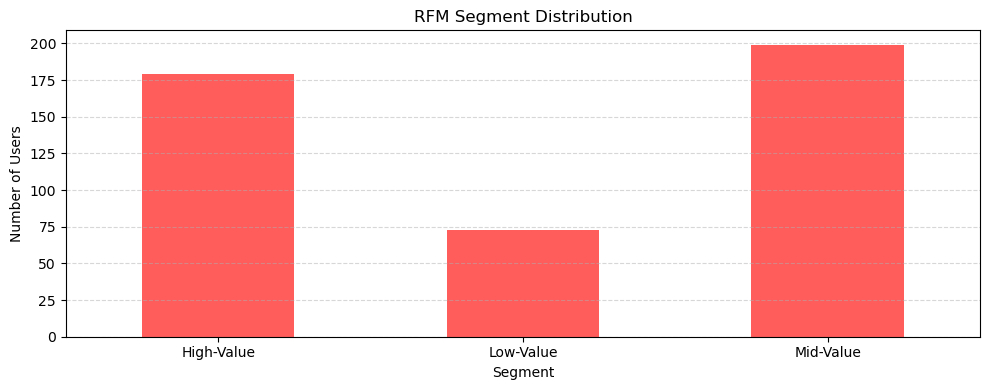

In [48]:
# Plot in bar chart
plt.figure(figsize=(10, 4))
segment_counts.plot(kind='bar', color='#FF5C5C')

plt.title('RFM Segment Distribution')
plt.xlabel('Segment')
plt.ylabel('Number of Users')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

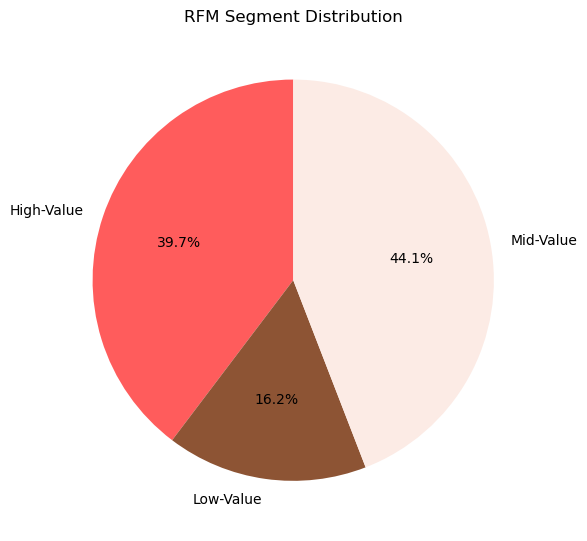

In [49]:
segment_colors = {
    'Low-Value': '#8D5434',
    'Mid-Value': '#FCEBE5',
    'High-Value': '#FF5C5C'
}
colors = [segment_colors[label] for label in segment_counts.index]

# Plot in pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    segment_counts,
    labels=segment_counts.index,

    autopct='%1.1f%%',
    startangle=90,
    colors=colors
)

plt.title('RFM Segment Distribution')
plt.tight_layout()
plt.show()

### 4.2 Clusterization (to understand differneces between them)



In [50]:
# Copiar o DataFrame
purchases_dates_cluster_df = purchases_dates_df.copy() 

# Calcular limite inferior (1 ano atrás)
one_year_ago = reference_date - timedelta(days=365)

# Filtrar para manter apenas registros no intervalo desejado
purchases_dates_cluster_df = purchases_dates_cluster_df[
    purchases_dates_cluster_df['WINDOW_END_TS_PST'].between(one_year_ago, reference_date)
]

# Cálculos auxiliares
purchases_dates_cluster_df['TOTAL_REVENUE'] = purchases_dates_cluster_df['CART_QUANTITY'] * purchases_dates_cluster_df['SALE_PRICE']
#purchases_dates_cluster_df['PROFIT'] = purchases_dates_cluster_df['TOTAL_REVENUE'] - (purchases_dates_cluster_df['CART_QUANTITY'] * purchases_dates_cluster_df['COGS'])

# Agrupando por userID
purchases_aggregated_df = (
    purchases_dates_cluster_df
    .groupby('userID')
    .agg({
        #'CART_QUANTITY': 'sum',
        'TOTAL_REVENUE': 'sum',
        #'PROFIT': 'sum',
        'SKU': 'nunique',
        #'CATEGORY': 'nunique'
    })
    .reset_index()
    .rename(columns={
        #'CART_QUANTITY': 'TOTAL_CART_QUANTITY',
        'SKU': 'UNIQUE_SKU_COUNT',
        #'CATEGORY': 'UNIQUE_CATEGORY_COUNT'
    })
)

# # Average item price
# purchases_aggregated_df['AVG_ITEM_PRICE'] = (
#     purchases_aggregated_df['TOTAL_REVENUE'] / purchases_aggregated_df['TOTAL_CART_QUANTITY']
# )

# # Margem percentual
# purchases_aggregated_df['MARGIN_PCT'] = (
#     purchases_aggregated_df['PROFIT'] / purchases_aggregated_df['TOTAL_REVENUE']
# )

# Calcular limite inferior (1 ano atrás)
one_year_ago = reference_date - timedelta(days=365)

# Filtrar visitas no último ano
filtered_visits_df = fact_visits_df[
    fact_visits_df['WINDOW_END_TS_PST'].between(one_year_ago, reference_date)
].copy()

# Agrupar por userID e somar VISIT_CNT
visits_aggregated_df = (
    filtered_visits_df
    .groupby('userID', as_index=False)['VISIT_CNT']
    .sum()
    .rename(columns={'VISIT_CNT': 'TOTAL_VISIT_CNT'})
)

# Inner join entre métricas de compra e visita
kmeans_features = purchases_aggregated_df.merge(
    visits_aggregated_df,
    on='userID',
    how='inner'
)

# # Selecionar apenas as colunas necessárias da fact_acquisitions_df
# ltv_df = fact_acquisitions_df[['userID', 'LTV14 (in cents)']].copy()

# # Inner join com user_metrics_df
# kmeans_features = user_metrics_df.merge(
#     ltv_df,
#     on='userID',
#     how='inner'
# )

# # Average items per visit
# kmeans_features['AVG_ITEMS_PER_VISIT'] = (
#     kmeans_features['TOTAL_CART_QUANTITY'] / kmeans_features['TOTAL_VISIT_CNT']
# )

# # Revenue per visit
# kmeans_features['REVENUE_PER_VISIT'] = (
#     kmeans_features['TOTAL_REVENUE'] / kmeans_features['TOTAL_VISIT_CNT']
# )

# Exibir resultado
kmeans_features.head()


,userID,TOTAL_REVENUE,UNIQUE_SKU_COUNT,TOTAL_VISIT_CNT
0,00e1652e0a249f65810507ce2a6ded73,145.98,8,31
1,01186aab51de65876d40e758b398ac3a,35.00,2,5
2,011a108b9bbe8e6a494e23d2cf782f4a,11.00,1,9
3,015c290d8fc1087c0e835f513f1b924e,119.97,7,7
4,01653f6844293d8e9e6e6e736f78cdb3,157.98,10,14


In [51]:
# # Copiar o DataFrame
# purchases_dates_cluster_df = purchases_dates_df.copy() 

# # Calcular limite inferior (1 ano atrás)
# one_year_ago = reference_date - timedelta(days=365)

# # Filtrar para manter apenas registros no intervalo desejado
# purchases_dates_cluster_df = purchases_dates_cluster_df[
#     purchases_dates_cluster_df['WINDOW_END_TS_PST'].between(one_year_ago, reference_date)
# ]

# # Cálculos auxiliares
# purchases_dates_cluster_df['TOTAL_REVENUE'] = purchases_dates_cluster_df['CART_QUANTITY'] * purchases_dates_cluster_df['SALE_PRICE']
# purchases_dates_cluster_df['PROFIT'] = purchases_dates_cluster_df['TOTAL_REVENUE'] - (purchases_dates_cluster_df['CART_QUANTITY'] * purchases_dates_cluster_df['COGS'])

# # Agrupando por userID
# purchases_aggregated_df = (
#     purchases_dates_cluster_df
#     .groupby('userID')
#     .agg({
#         'CART_QUANTITY': 'sum',
#         'TOTAL_REVENUE': 'sum',
#         'PROFIT': 'sum',
#         'SKU': 'nunique',
#         'CATEGORY': 'nunique'
#     })
#     .reset_index()
#     .rename(columns={
#         'CART_QUANTITY': 'TOTAL_CART_QUANTITY',
#         'SKU': 'UNIQUE_SKU_COUNT',
#         'CATEGORY': 'UNIQUE_CATEGORY_COUNT'
#     })
# )

# # Average item price
# purchases_aggregated_df['AVG_ITEM_PRICE'] = (
#     purchases_aggregated_df['TOTAL_REVENUE'] / purchases_aggregated_df['TOTAL_CART_QUANTITY']
# )

# # Margem percentual
# purchases_aggregated_df['MARGIN_PCT'] = (
#     purchases_aggregated_df['PROFIT'] / purchases_aggregated_df['TOTAL_REVENUE']
# )

# # Calcular limite inferior (1 ano atrás)
# one_year_ago = reference_date - timedelta(days=365)

# # Filtrar visitas no último ano
# filtered_visits_df = fact_visits_df[
#     fact_visits_df['WINDOW_END_TS_PST'].between(one_year_ago, reference_date)
# ].copy()

# # Agrupar por userID e somar VISIT_CNT
# visits_aggregated_df = (
#     filtered_visits_df
#     .groupby('userID', as_index=False)['VISIT_CNT']
#     .sum()
#     .rename(columns={'VISIT_CNT': 'TOTAL_VISIT_CNT'})
# )

# # Inner join entre métricas de compra e visita
# kmeans_features = purchases_aggregated_df.merge(
#     visits_aggregated_df,
#     on='userID',
#     how='inner'
# )

# # Selecionar apenas as colunas necessárias da fact_acquisitions_df
# ltv_df = fact_acquisitions_df[['userID', 'LTV14 (in cents)']].copy()

# # Inner join com user_metrics_df
# kmeans_features = kmeans_features.merge(
#     ltv_df,
#     on='userID',
#     how='inner'
# )

# # Average items per visit
# kmeans_features['AVG_ITEMS_PER_VISIT'] = (
#     kmeans_features['TOTAL_CART_QUANTITY'] / kmeans_features['TOTAL_VISIT_CNT']
# )

# # Revenue per visit
# kmeans_features['REVENUE_PER_VISIT'] = (
#     kmeans_features['TOTAL_REVENUE'] / kmeans_features['TOTAL_VISIT_CNT']
# )

# # Exibir resultado
# kmeans_features.head()


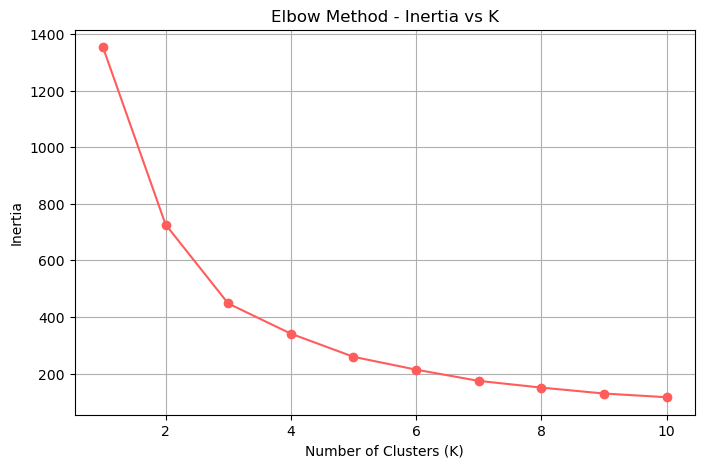

In [52]:
# 1. Seleciona só as colunas numéricas (já exclui userID do index)
X = kmeans_features.select_dtypes(include='number')

# 2. Escala os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Testa diferentes valores de K
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# 4. Plota o gráfico de Elbow
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', color='#FF5C5C')
plt.title('Elbow Method - Inertia vs K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

Let's understand the colinearity.

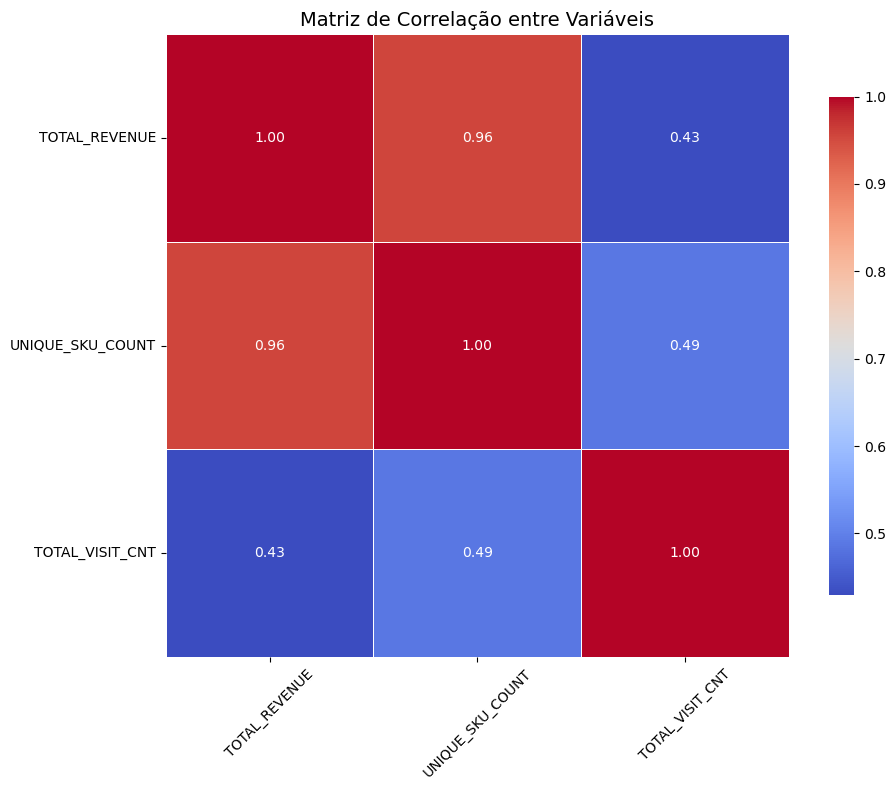

In [53]:
# Calcular correlação
corr_matrix = X.corr()

# Plotar heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, 
            annot=True,
            fmt=".2f",
            cmap='coolwarm',
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8})
plt.title("Matriz de Correlação entre Variáveis", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [54]:
# Seleciona as colunas numéricas
X = kmeans_features.select_dtypes(include='number')

# Cria o pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=3, random_state=42, n_init=10))
])

# Treina o modelo
pipeline.fit(X)

# Adiciona os rótulos (clusters) ao DataFrame
kmeans_features['cluster'] = pipeline.named_steps['kmeans'].labels_

In [55]:
cluster_summary = kmeans_features.groupby('cluster').mean(numeric_only=True)
display(cluster_summary)

,TOTAL_REVENUE,UNIQUE_SKU_COUNT,TOTAL_VISIT_CNT
cluster,,,
0,81.090571,4.925714,11.248571
1,1599.754286,79.071429,52.928571
2,398.962759,22.563218,44.206897


In [56]:
# Prepara os dados
X = kmeans_features.drop(columns=['cluster', 'userID'])
y = kmeans_features['cluster']

# Treina a árvore
tree = DecisionTreeClassifier(max_depth=5, random_state=42)
tree.fit(X, y)

# Coleta as importâncias
importances = pd.Series(tree.feature_importances_, index=X.columns)

# Ordena e normaliza para somar 100%
importances = importances.sort_values(ascending=False)
importances_percent = (importances / importances.sum()) * 100

# Exibe
display(importances_percent.round(2))

TOTAL_VISIT_CNT     57.83
UNIQUE_SKU_COUNT    35.46
TOTAL_REVENUE        6.71
dtype: float64

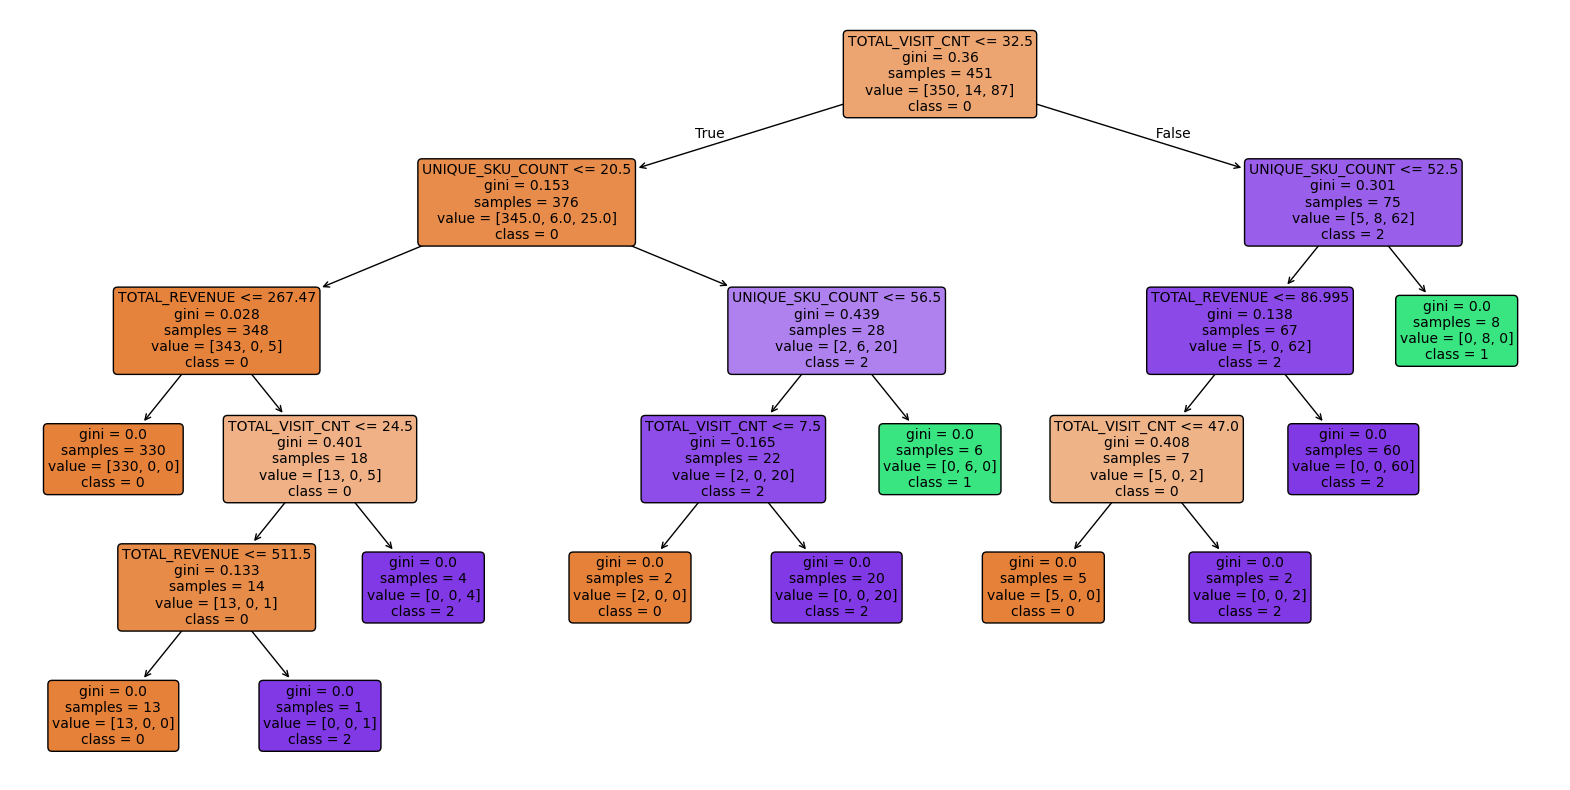

In [57]:
# Define o tamanho da figura
plt.figure(figsize=(20, 10))

# Plota a árvore
plot_tree(
    tree,
    feature_names=X.columns,
    class_names=[str(c) for c in tree.classes_],
    filled=True,
    rounded=True,
    fontsize=10
)

# Mostra o gráfico
plt.show()


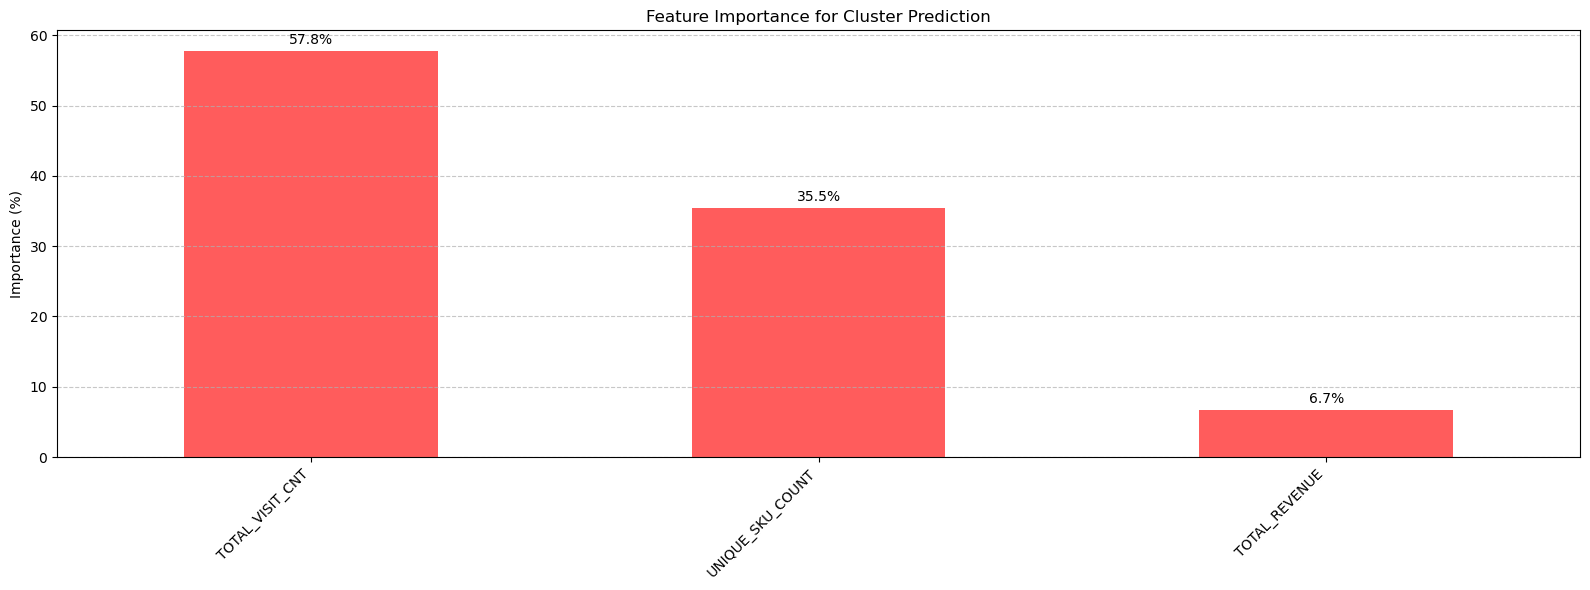

In [58]:
# Plot do gráfico com valores no topo
plt.figure(figsize=(16, 6))
ax = importances_percent.plot(kind='bar', color='#FF5C5C')
plt.ylabel('Importance (%)')
plt.title('Feature Importance for Cluster Prediction')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adiciona os valores acima de cada barra
for i, v in enumerate(importances_percent):
    ax.text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom', fontsize=10)

plt.show()

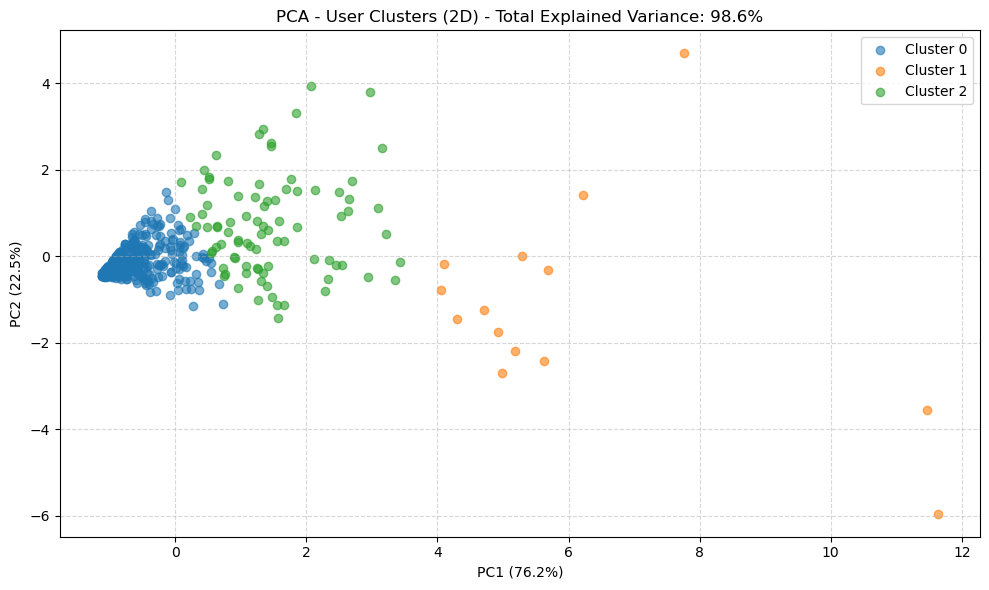

In [59]:
# Prepara os dados (sem userID e cluster)
X = kmeans_features.drop(columns=['cluster', 'userID'])

# Escala os dados
X_scaled = StandardScaler().fit_transform(X)

# Aplica PCA com 2 componentes
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Cria DataFrame com os componentes + cluster
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['cluster'] = kmeans_features['cluster'].values

# Calcula variância explicada
explained_var = pca.explained_variance_ratio_
explained_pc1 = explained_var[0] * 100
explained_pc2 = explained_var[1] * 100
explained_total = explained_pc1 + explained_pc2

# Plota o scatter plot 2D
plt.figure(figsize=(10, 6))
for cluster_id in sorted(pca_df['cluster'].unique()):
    subset = pca_df[pca_df['cluster'] == cluster_id]
    plt.scatter(subset['PC1'], subset['PC2'], label=f'Cluster {cluster_id}', alpha=0.6)

plt.xlabel(f'PC1 ({explained_pc1:.1f}%)')
plt.ylabel(f'PC2 ({explained_pc2:.1f}%)')
plt.title(f'PCA - User Clusters (2D) - Total Explained Variance: {explained_total:.1f}%')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [60]:
# Garante que userID seja string em ambos
rfm_df['userID'] = rfm_df['userID'].astype(str)
kmeans_features['userID'] = kmeans_features['userID'].astype(str)

# Faz o merge normalmente
rfm_with_clusters = rfm_df.merge(
    kmeans_features[['userID', 'cluster']],
    on='userID',
    how='left'
)

#
rfm_with_clusters.head()

,userID,RECENCY,FREQUENCY,MONETARY,R,F,M,RFM_Segment,RFM_SCORE,RFM_SEGMENT_LABEL,cluster
0,00e1652e0a249f65810507ce2a6ded73,0,9,145.98,4,3,3,433,10,High-Value,0
1,01186aab51de65876d40e758b398ac3a,273,2,35.00,1,1,2,112,4,Low-Value,0
2,011a108b9bbe8e6a494e23d2cf782f4a,20,1,11.00,3,1,1,311,5,Mid-Value,0
3,015c290d8fc1087c0e835f513f1b924e,287,7,119.97,1,3,3,133,7,Mid-Value,0
4,01653f6844293d8e9e6e6e736f78cdb3,105,10,157.98,3,3,3,333,9,High-Value,0


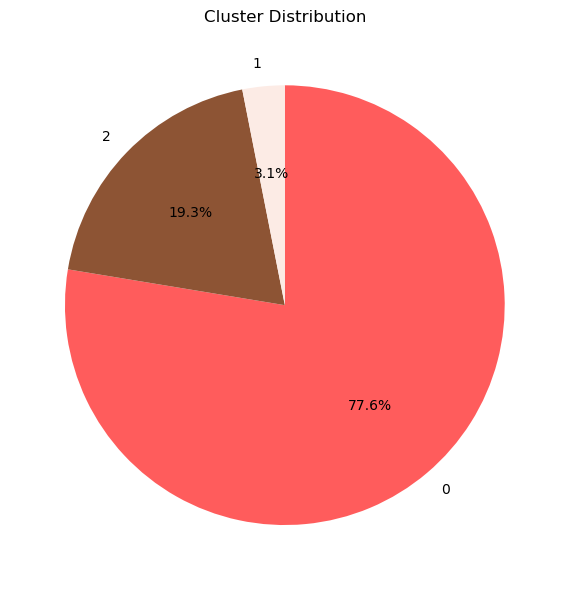

In [61]:
segment_colors = {
    'Low-Value': '#8D5434',
    'Mid-Value': '#FCEBE5',
    'High-Value': '#FF5C5C'
}
colors = [segment_colors[label] for label in segment_counts.index]

# Conta os valores por cluster
cluster_counts = rfm_with_clusters['cluster'].value_counts()

# Plota o gráfico de pizza com porcentagens
plt.figure(figsize=(6, 6))
plt.pie(
    cluster_counts,
    labels=cluster_counts.index,
    autopct='%.1f%%',
    startangle=90,
    counterclock=False,
    colors=colors
)
plt.title('Cluster Distribution')
plt.tight_layout()
plt.show()

<Axes: xlabel='cluster', ylabel='MONETARY'>

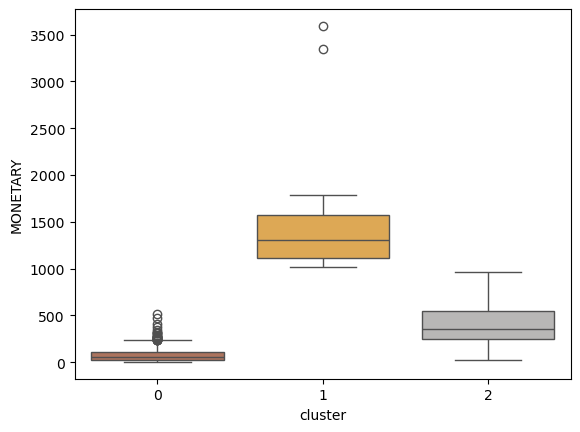

In [62]:
palette = {
    '0': '#B96F51',
    '1': '#F4AD3E',
    '2': '#B8B7B6'
}

sns.boxplot(
    x='cluster',
    y='MONETARY',
    data=rfm_with_clusters,
    palette=palette
)


<Axes: xlabel='cluster', ylabel='RECENCY'>

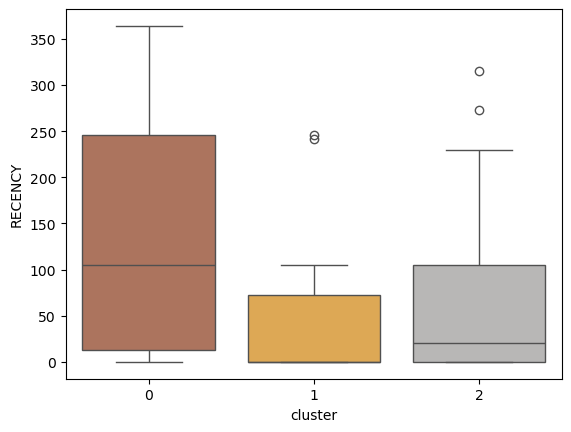

In [63]:
palette = {
    '0': '#B96F51',
    '1': '#F4AD3E',
    '2': '#B8B7B6'
}

sns.boxplot(
    x='cluster',
    y='RECENCY',
    data=rfm_with_clusters,
    palette=palette
)

<Axes: xlabel='cluster', ylabel='FREQUENCY'>

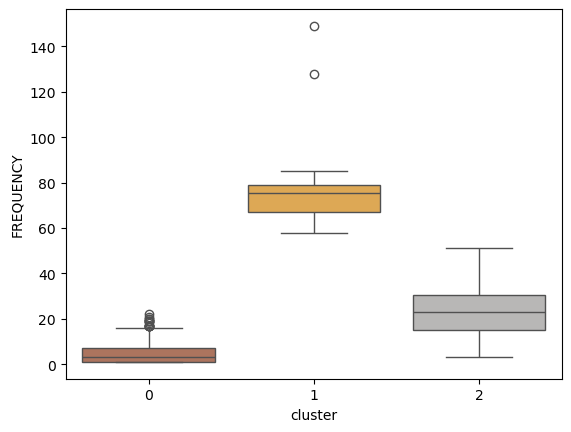

In [64]:
palette = {
    '0': '#B96F51',
    '1': '#F4AD3E',
    '2': '#B8B7B6'
}

sns.boxplot(
    x='cluster',
    y='FREQUENCY',
    data=rfm_with_clusters,
    palette=palette
)

### 4.3 Channels with Valuable users



Let's get the final WINDOW_END_TS_PST and the last visit cnt. Sum the other visit cnt with the same channel of convertion.

In [90]:
# 1. Define intervalo de 1 ano
reference_date = fact_visits_df['WINDOW_END_TS_PST'].max()
one_year_ago   = reference_date - timedelta(days=365)

# 2. Última visita por user + campanha (para capturar canal de conversão)
last_visits = (
    fact_visits_df
    .sort_values('WINDOW_END_TS_PST')
    .drop_duplicates(subset=['userID', 'CAMPAIGN_ID'], keep='last')
    [['userID', 'CAMPAIGN_ID', 'CHANNEL']]
    .rename(columns={'CHANNEL': 'LAST_CHANNEL'})
)

# 3. Filtra todas as visitas no mesmo canal da última visita
# Faz join de todas as visitas com o canal da última visita
visits_with_last_channel = fact_visits_df.merge(
    last_visits,
    on=['userID', 'CAMPAIGN_ID'],
    how='inner'
)

# Filtra visitas com mesmo canal da última
visits_same_channel = visits_with_last_channel[
    visits_with_last_channel['CHANNEL'] == visits_with_last_channel['LAST_CHANNEL']
]

# 4. Soma o VISIT_CNT por userID + CAMPAIGN_ID + CHANNEL
visit_cnt_sum = (
    visits_same_channel
    .groupby(['userID', 'CAMPAIGN_ID', 'CHANNEL'], as_index=False)
    ['VISIT_CNT'].sum()
    .rename(columns={'VISIT_CNT': 'VISIT_CNT_SUM'})
)

# 5. Última visita completa (com datas e canal) → vamos fazer o merge com compras
last_visits_full = (
    fact_visits_df
    .sort_values('WINDOW_END_TS_PST')
    .drop_duplicates(subset=['userID', 'CAMPAIGN_ID'], keep='last')
    [['userID', 'CAMPAIGN_ID', 'CHANNEL', 'WINDOW_END_TS_PST', 'WINDOW_NUMBER']]
)

# 6. Join com fact_purchases_df → mantém só usuários que compraram
purchases_dates_df = fact_purchases_df.merge(
    last_visits_full,
    on=['userID', 'CAMPAIGN_ID'],
    how='inner'
)

# 7. Join com a soma do VISIT_CNT para o mesmo canal
purchases_dates_df = purchases_dates_df.merge(
    visit_cnt_sum,
    on=['userID', 'CAMPAIGN_ID', 'CHANNEL'],
    how='left'
)

# 8. Calcula TOTAL_REVENUE
purchases_dates_df['TOTAL_REVENUE'] = (
    purchases_dates_df['CART_QUANTITY'] * purchases_dates_df['SALE_PRICE']
)

# 9. Filtra intervalo de 1 ano e usuários RFM
filtered_purchases = purchases_dates_df[
    (purchases_dates_df['WINDOW_END_TS_PST'].between(one_year_ago, reference_date)) &
    (purchases_dates_df['userID'].isin(rfm_with_clusters['userID']))
].copy()

# 10. Cria coluna de mês
filtered_purchases['MONTH'] = filtered_purchases['WINDOW_END_TS_PST'].dt.to_period('M')

# 11. Soma total de VISIT_CNT (ajustado) por mês e canal
channel_monthly_purchases = (
    filtered_purchases
    .groupby(['MONTH', 'CHANNEL'], as_index=False)
    ['VISIT_CNT_SUM'].sum()
    .rename(columns={'VISIT_CNT_SUM': 'TOTAL_VISITS'})
)

# Resultado final
display(channel_monthly_purchases)


,MONTH,CHANNEL,TOTAL_VISITS
0,2023-08,Facebook,10
1,2023-08,Non-Attributed,519
2,2023-08,crm_email,31
3,2023-08,crm_sms,14
4,2023-08,mobile_android,154
...,...,...,...
69,2024-08,Non-Attributed,395
70,2024-08,Rakuten,20
71,2024-08,crm_email,16
72,2024-08,mobile_android,103


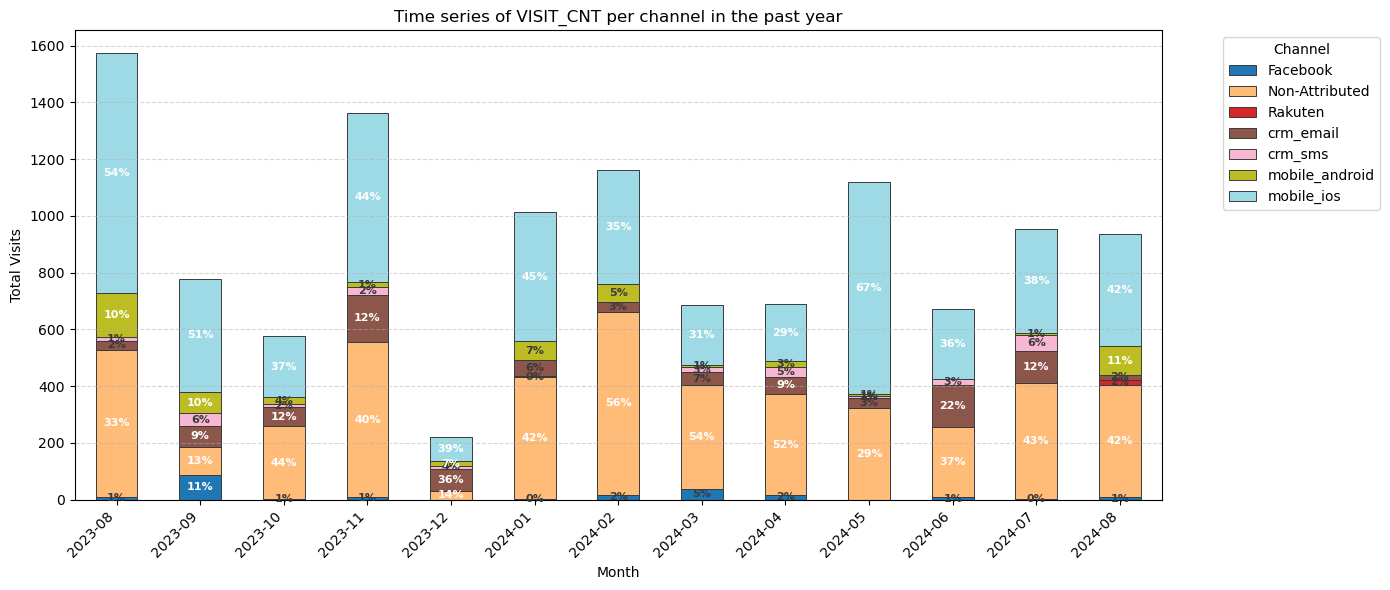

In [91]:
# 1. Pivot: soma de visitas por mês e canal
pivot_df = (
    channel_monthly_purchases
    .pivot(index='MONTH', columns='CHANNEL', values='TOTAL_VISITS')
    .fillna(0)
    .sort_index()
)

# 2. Plota gráfico de barras empilhadas
ax = pivot_df.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 6),
    colormap='tab20',
    edgecolor='#3A3A3A',
    linewidth=0.7
)

# 3. Adiciona % em cada stack
# Para cada mês (coluna da barra)
for i, (month, row) in enumerate(pivot_df.iterrows()):
    total = row.sum()
    y_offset = 0
    for channel in pivot_df.columns:
        value = row[channel]
        if value > 0:
            percent = (value / total) * 100
            ax.text(
                x=i,
                y=y_offset + value / 2,
                s=f'{percent:.0f}%',
                ha='center',
                va='center',
                fontsize=8,
                color='white' if percent > 7 else '#3A3A3A',
                fontweight='bold'
            )
            y_offset += value

# 4. Estética
ax.set_title('Time series of VISIT_CNT per channel in the past year')
ax.set_ylabel('Total Visits')
ax.set_xlabel('Month')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Channel', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 4.4 CONVERTION

In [92]:
# Copiar o DataFrame
visitors_df = purchases_dates_df.copy() 

# Calcular limite inferior (1 ano atrás)
one_year_ago = reference_date - timedelta(days=365)

# Filtrar para manter apenas registros no intervalo desejado
visitors_df = visitors_df[
    visitors_df['WINDOW_END_TS_PST'].between(one_year_ago, reference_date)
]

visitors_df.head()

,userID,CAMPAIGN_ID,CAMPAIGN_TITLE,SKU,CART_QUANTITY,MSRP,COGS,SALE_PRICE,CATEGORY,CHANNEL,WINDOW_END_TS_PST,WINDOW_NUMBER,VISIT_CNT_SUM,TOTAL_REVENUE
250,0f58d1f389e2aea8e6a8a4156162ff9e,221,Fall 2023 Add Ons,STE-FA-1698-DS,1,56.0,NaN,26.00,Fashion,mobile_ios,2023-08-08 23:59:59+00:00,2,4,26.00
251,b793f46693d38e963310924090416a14,221,Fall 2023 Add Ons,FAO-BU-106,1,115.0,10.15,19.99,Bundles,Non-Attributed,2023-08-08 23:59:59+00:00,2,4,19.99
252,18f7c9c78cac2a229e4d1fdb660d3010,221,Fall 2023 Add Ons,BUT-BE-069,1,52.0,6.24,19.00,Beauty,mobile_ios,2023-08-08 23:59:59+00:00,2,10,19.00
253,78a9010ba8f760ee66122aeff95045f1,221,Fall 2023 Add Ons,NEC-BE-004,1,30.0,10.20,25.00,Beauty,mobile_ios,2023-08-08 23:59:59+00:00,2,1,25.00
255,71d22a5154349ab034ed17da71d199b1,221,Fall 2023 Add Ons,KIT-FA-033,1,10.0,2.50,6.00,Fashion,mobile_ios,2023-08-08 23:59:59+00:00,2,3,6.00


In [93]:
# 1. Filtro de tempo
one_year_ago = reference_date - timedelta(days=365)

fact_visits_filtered_df = fact_visits_df[
    fact_visits_df['WINDOW_END_TS_PST'].between(one_year_ago, reference_date)
]

purchases_dates_filtered_df = purchases_dates_df[
    purchases_dates_df['WINDOW_END_TS_PST'].between(one_year_ago, reference_date)
]

# 2. Total de VISITAS com região
visitors = (
    fact_visits_filtered_df
    .groupby(['userID', 'CAMPAIGN_ID'], as_index=False)
    .agg(total_visits=('VISIT_CNT', 'sum'))  # soma total de VISIT_CNT por user/campaign
    .merge(fact_acquisitions_df[['userID', 'USER_REGION']], on='userID', how='left')
)

# 3. Compradores com região (1 compra = 1 conversão, sem contar qtd de itens)
buyers = (
    purchases_dates_filtered_df[['userID', 'CAMPAIGN_ID']]
    .drop_duplicates()  # 1 compra por user-campaign
    .merge(fact_acquisitions_df[['userID', 'USER_REGION']], on='userID', how='left')
    .assign(bought=1)
)

# 4. Merge de visitantes com compradores
conversion_df = visitors.merge(
    buyers[['userID', 'CAMPAIGN_ID', 'bought']],
    on=['userID', 'CAMPAIGN_ID'],
    how='left'
)

conversion_df['bought'] = conversion_df['bought'].fillna(0)

# 5. Conversão por região
conversion_by_region = (
    conversion_df
    .groupby('USER_REGION')
    .agg(
        total_visits=('total_visits', 'sum'),  # soma de visitas (com VISIT_CNT)
        total_bought=('bought', 'sum')         # número de conversões
    )
    .reset_index()
)

conversion_by_region['conversion_rate'] = (
    conversion_by_region['total_bought'] / conversion_by_region['total_visits'] * 100
)

# Exibir resultado
conversion_by_region.head()

,USER_REGION,total_visits,total_bought,conversion_rate
0,Canada,1059,150.0,14.164306
1,Military,4,0.0,0.000000
2,Non-Continental US,36,7.0,19.444444
3,Other,98,5.0,5.102041
4,US-Midwest,1921,253.0,13.170224


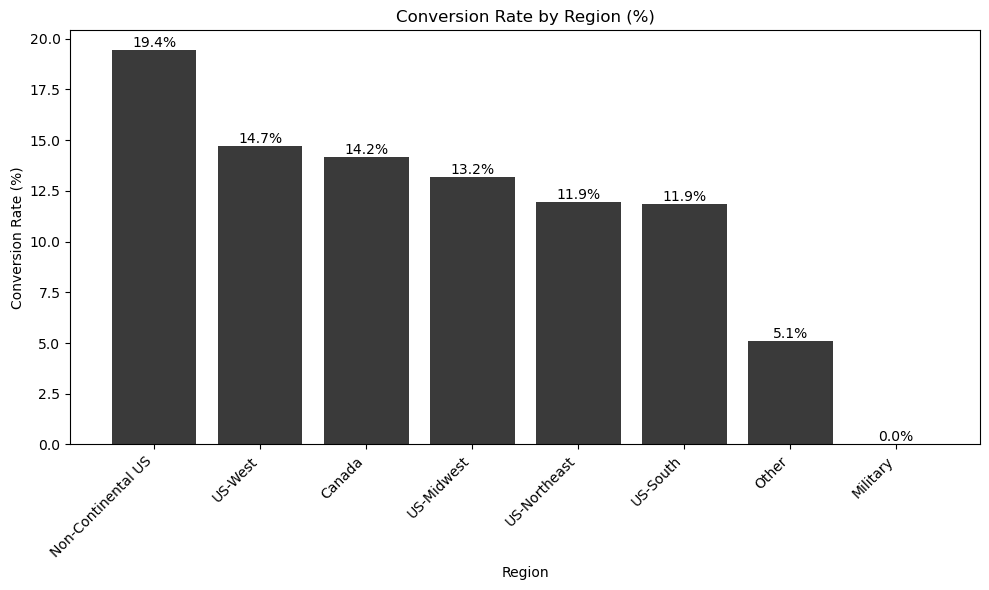

In [94]:
# Sort by conversion rate
conversion_by_region = conversion_by_region.sort_values(by='conversion_rate', ascending=False)

# Data
regions = conversion_by_region['USER_REGION']
conversion_rates = conversion_by_region['conversion_rate']

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(regions, conversion_rates, color='#3A3A3A')

# Add labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:.1f}%',
        ha='center',
        va='bottom',
        fontsize=10
    )

# Aesthetics
plt.ylabel('Conversion Rate (%)')
plt.xlabel('Region')
plt.title('Conversion Rate by Region (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()